# Прогноз стоимости подержанных автомобилей

## Содержание

**[1. Обзор данных](#1)**

- **[1.1 Ввод необходимых функций](#1.1)**
- **[1.2 Разведочный анализ данных](#1.2)**
- **[1.3 Общие выводы по качеству имеющихся данных](#1.3)**


**[2. Подготовка данных](#2)**

- **[2.1. Предобработка данных](#2.1)**
- **[2.2. Проверка данных на мультиколлинеарность](#2.2)**
- **[2.3. Общие выводы по подготовке данных ](#2.3)**


**[3. Обучение моделей](#3)**

- **[3.1. Пробразование категорий в число](#3.1)**
- **[3.2. Проверка метода word_str. Объединение значений символов](#3.2)**
- **[3.3. Проверка метода word_int. Сумма значений символов](#3.3)**
- **[3.4. Модель линейной регрессии](#3.4)**
- **[3.5. Модель Решающего дерева](#3.5)**
- **[3.6. Методы улучшения качества моделей](#3.6)**
- **[3.7. Общие выводы](#3.7)**


**[4. Подготовка контрольного датасета](#4)**

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

Предлагаем вам принять участие в Мастерской, в рамках которой вы сможете поработать с данными о продажах автомобилей на вторичном рынке. Целью вашего проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

Основной критерий победы в соревновании - точность предсказания.

**Соревнование на платформе Kaggle.** Стоимость поддержанного автомобиля. Предскажи стоимость автомобиля на вторичном рынке.

**Цель Соревнования.** Разработка модели, которая достигнет наилучшего значения показателя `MAPE` (Mean Absolute Percentage Error).

**Цель исследования.** Построить модель для определения стоимости автомобиля с высоким качеством предсказания.

**Задачи:**
- загрузить и ознакомится с данными,
- провести предварительную обработку,
- сделать полноценный разведочный анализ,
- разработать новые синтетические признаки,
- проверить на мультиколлинеарность,
- сделать отбор финального набора обучающих признаков,
- выбрать и обучить модели,
- провести итоговую оценку качества предсказания лучшей модели,
- сделать анализ важности признаков модели.

**Входные данные.** Три файла в формате `.csv` с данными о продаваемых машинах:
1. `train.csv` - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.
2. `test.csv` - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных.
3. `sample_submission.csv` - пример файла предсказаний в правильном формате.

**Формальная задача.** Предсказать значение `'sellingprice'` для каждого автомобиля из датасета `test.csv`.

**Ожидаемый результат.** Построена модель для определения стоимости автомобиля, со значением метрики `MAPE` не более **15**.


## Обзор данных <a id='1'></a>

**Признаки**

- `year` – год выпуска автомобиля.
- `make` – марка автомобиля.
- `model` – модель автомобиля определенной марки.
- `trim` – уровень отделки салона автомобиля.
- `body` – тип кузова транспортного средства.
- `transmission` – тип коробки передач.
- `vin` – идентификационный номер транспортного средства.
- `state` – состояние, в котором автомобиль выставлен на аукцион.
- `condition` – оценка состояние автомобилей на момент аукциона.
- `odometer` – расстояние, пройденное автомобилем с момента выпуска.
- `color` – цвет кузова автомобиля.
- `interior` – цвет салона автомобиля.
- `seller` – продавец автомобиля, автосалоны.
- `saledate` – дата продажи автомобиля. 

**Целевой признак**

- `sellingprice` – цена, по которой автомобиль был продан на аукционе.

In [1]:
# Импорт библиотек
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from time import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

In [2]:
# Введем константу
state = RandomState(12345)

### Ввод необходимых функций <a id='1.1'></a>

In [3]:
# Функция исследования датасета
def info_df(df_name):
    st = df_name.shape[0]
    col = df_name.shape[1]
    zerro = df_name.isna().sum()
    vin = len(df_name['vin'].unique())
    print(f'Размер таблиы: {col} столбцов и {st} строк')
    print(f'Общее количество пропусков - {zerro.sum()}')
    print(df_name.isna().sum())
    print()
    print(f'Количество явных дубликатов: {df_name.duplicated().sum()}')
    print(f'Количество уникальных VIN: {vin}')
    print()
    print(df_name.info())
    print()
    display(df_name.describe().round(2))

In [4]:
# Функция построения типовых гистограмм
def hist_pattern(df, title):
    df.hist(bins=50, figsize=(6,4))
    plt.title(title)
    return plt.show()


In [5]:
# Функция преобразования слова в число
def word_int(word):
    list_word = list(word) # Преобразуем слово в список
    list_int = [] 
    
    # Преобразуем каждую букву списка в число
    for i in range(len(list_word)):
        list_int.append((i+1)*ord(list_word[i]))
    
    return sum(list_int) # вернем сумму чисел

In [6]:
# Функция преобразования слова в строку чисел
def word_str(word):
    list_word = list(word) # Преобразуем слово в список
    list_str = [] 
    
    # Преобразуем каждую букву списка в число строкового типа 
    for i in range(len(list_word)):
        list_str.append(str((i+1)*ord(list_word[i])))
    
    return int(''.join(list_str)) # вернем строку чисел

In [7]:
# Функция преобразования месяца в время года
# 1 - Зима
# 2 - Весна
# 3 - Лето
# 4 - Осень

def season(month):
    if month == 1 or month == 2 or month == 12:
        return 1
    elif month == 3 or month == 4 or month == 5:
        return 2
    elif month == 6 or month == 7 or month == 8:
        return 3
    elif month == 9 or month == 10 or month == 11:
        return 4
        

### Разведочный анализ данных <a id='1.2'></a>

In [8]:
# Чтение файлов
path = 'C:\\Users\\User\\first_notebook\\Praktikum\\auto_prixe_predict\\'

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df_sample = pd.read_csv(path + 'sample_submission.csv')


In [9]:
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)


In [10]:
df_train['vin_transmis'] = df_train['vin'].apply(lambda x: x[6])

In [11]:
# Обследуем данные
info_df(df_train)

Размер таблиы: 16 столбцов и 440236 строк
Общее количество пропусков - 97003
year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
vin_transmis        0
dtype: int64

Количество явных дубликатов: 0
Количество уникальных VIN: 440236

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 no

,year,condition,odometer,sellingprice
count,440236.00,430831.00,440167.00,440236.00
mean,2010.04,3.43,68344.42,13592.21
std,3.98,0.95,53542.20,9751.48
min,1982.00,1.00,1.00,1.00
25%,2007.00,2.70,28258.00,6900.00
50%,2012.00,3.60,52098.00,12100.00
75%,2013.00,4.20,99272.00,18200.00
max,2015.00,5.00,999999.00,230000.00


**Расмотрим данные по году выпуска**

In [12]:
# Исследуем год выпуска
df_train['year'].unique()

array([2011, 2014, 2012, 2003, 2007, 2013, 2010, 2000, 2005, 2006, 2004,
       2008, 2009, 2015, 2002, 2001, 1999, 1998, 1996, 1997, 1994, 1995,
       1993, 1989, 1991, 1988, 1987, 1990, 1992, 1985, 1986, 1983, 1984,
       1982], dtype=int64)

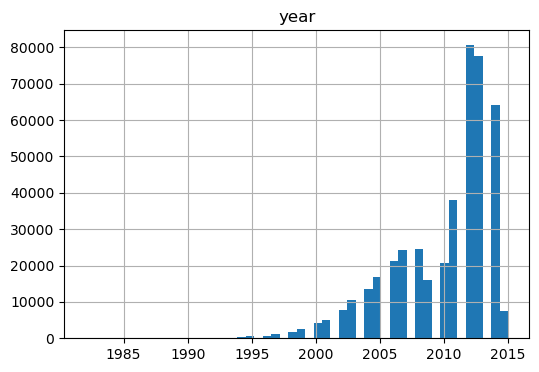

In [13]:
hist_pattern(df_train['year'], 'year')

<Axes: xlabel='sellingprice', ylabel='year'>

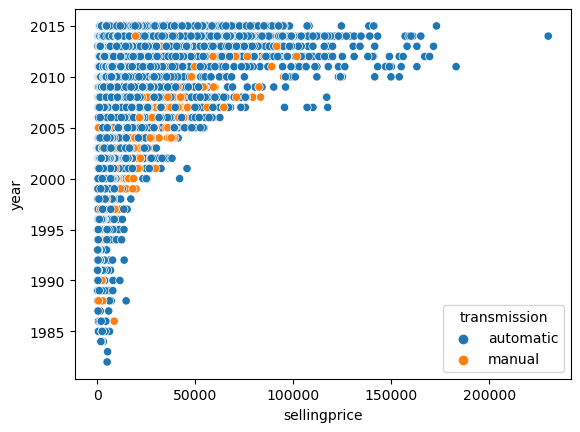

In [14]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="year", 
    hue="transmission", 
)

**Расмотрим данные по состоянию автомобиля**

In [15]:
# Исследуем состояние автомобиля
df_train['condition'].unique()

array([4.2, 3.5, 2.2, 2.8, 2. , 2.5, 3.4, 4.8, 1.9, 1. , 3.1, 2.7, 3.6,
       2.9, 4.1, 2.6, 2.1, 3. , 4.9, 4.7, 4. , 3.3, 3.8, 3.7, 4.5, 4.6,
       5. , 4.3, 2.4, 2.3, 3.9, nan, 3.2, 4.4, 1.4, 1.5, 1.7, 1.2, 1.3,
       1.6, 1.8, 1.1])

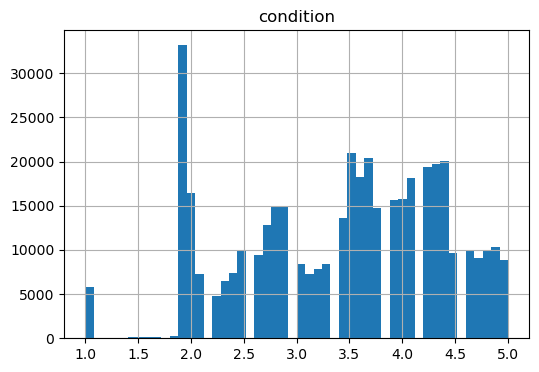

In [16]:
hist_pattern(df_train['condition'], 'condition')

<Axes: xlabel='sellingprice', ylabel='condition'>

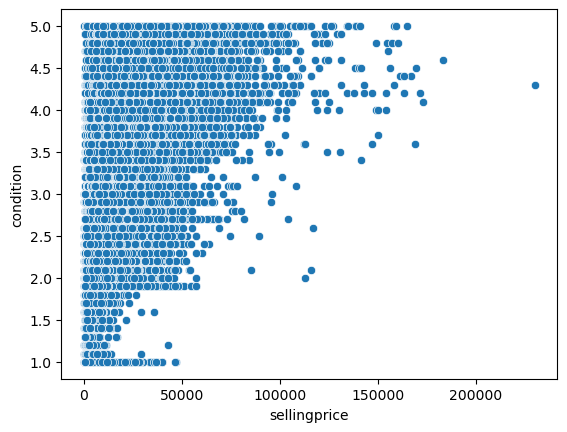

In [17]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="condition", 
)

**Расмотрим данные по пробегу автомобиля**

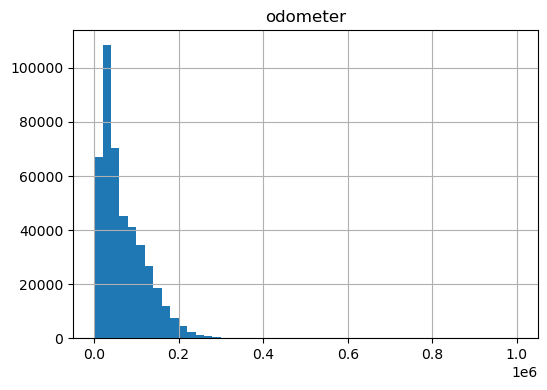

In [18]:
hist_pattern(df_train['odometer'], 'odometer')

<Axes: xlabel='sellingprice', ylabel='odometer'>

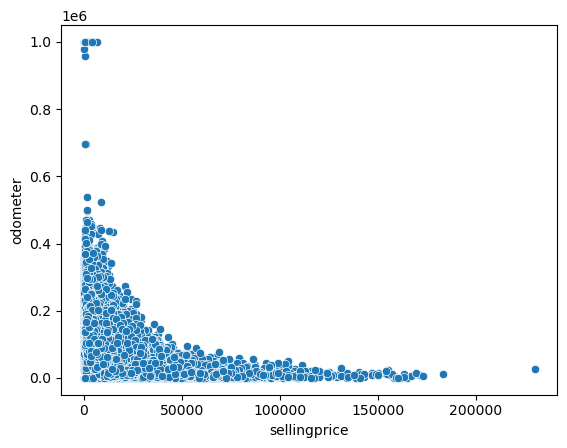

In [19]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="odometer" 
)

**Расмотрим данные по цене автомобиля**

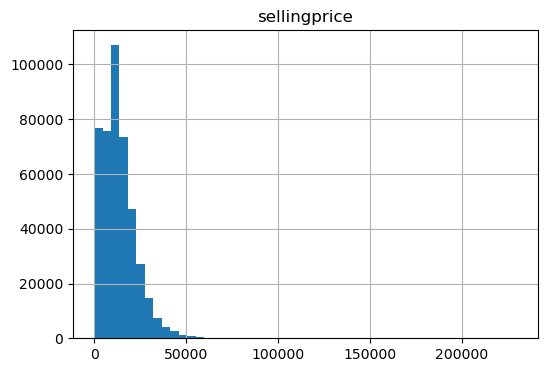

In [20]:
hist_pattern(df_train['sellingprice'], 'sellingprice')

In [21]:
# Определим состав признака sellingprice
df_train['sellingprice'].value_counts().sort_index()

1          2
100       16
125        1
150       18
175       10
          ..
169500     1
171500     1
173000     1
183000     1
230000     1
Name: sellingprice, Length: 1735, dtype: int64

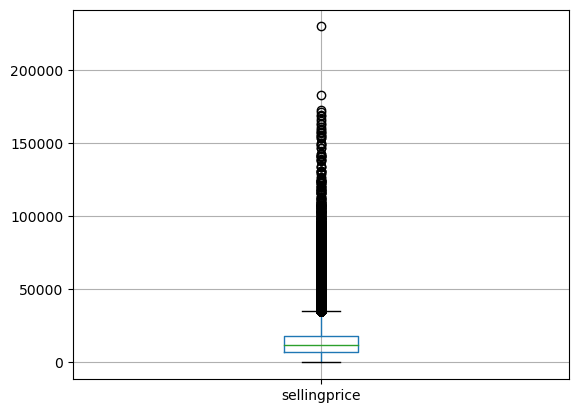

In [22]:
# Изобразим выбросы на графике
df_train.loc[:, ['sellingprice']].boxplot()
plt.show()

In [23]:
# Определим верхний уровень выбросов
price_mean = df_train['sellingprice'].mean()
price_std = np.std(list(df_train['sellingprice']), ddof=1)
sig_max = price_mean + 3 * price_std
print('Верхний уровень выброса - ', sig_max)

Верхний уровень выброса -  42846.64688071322


In [24]:
# Определим нижний уровень выбросов
print('Нижний уровень выброса - ', df_train['sellingprice'].quantile(0.05))

Нижний уровень выброса -  1500.0


In [25]:
price_list = df_train['sellingprice'].value_counts().sort_index()
print('Количество нижних выбросов', price_list[price_list.index < 1500].sum())
print('Количество верхних выбросов', price_list[price_list.index > 42846].sum())

Количество нижних выбросов 21223
Количество верхних выбросов 5446


Судя по графику и значению квантиля 5% – выбросом является цены со значением менее 1 500 (21 223 повторения).

Используя правило трех сигм определена верхняя граница выброса – 42 846 (5 446 повторений)

In [26]:
# Определим состав признака odometer
df_train['odometer'].value_counts().sort_index()

1.0         1059
2.0           11
3.0            6
4.0            8
5.0            8
            ... 
537334.0       1
694978.0       2
959276.0       1
980113.0       1
999999.0      55
Name: odometer, Length: 159364, dtype: int64

In [27]:
odometer_list = df_train['odometer'].value_counts().sort_index()
print('Количество данных верхнего выброса', odometer_list[odometer_list.index > 500000].sum())

Количество данных верхнего выброса 62


In [28]:
# Список категориальных признаков
list_clusters = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

In [29]:
# Число уникальных значений в каждлом категориальном столбце
for i in list_clusters:
    print(i, '-', len(df_train[i].unique()))

make - 93
model - 960
trim - 1923
body - 86
transmission - 3
state - 38
color - 21
interior - 18
seller - 13025


### Общие выводы по качеству имеющихся данных <a id='1.3'></a>

Датасет содержит `15` столбцов и `440 236` строк. Общее число пропусков `97 003`.

Основные показатели датасета имеют отклонения от нормального распределения. 

Данные по годам выпуска автомобилей (`year`) смещены вправо. В основном, на рынке представлены автомобили с `2010` по `2015` гг. Есть ряд данных до `1995` года, которые могут считаться аномалиями. Стоимость таких автомобилей очень низкая и они будут оказывать отрицательное влияние на обучение модели. Из графика также видно очень незначительное количество автомобилей с ручной коробкой передач. Такой перекос данных также окажет негативное влияние на итоговую оценку. При этом, имеет место зависимость между ценой продажи и годом, что наглядно показано на графике.

Параметр состояния автомобиля (`condition`) также коррелирует с ценой продажи, но в отличии от года выпуска имеет более равномерное распределение (низкую степень смещения показывает незначительное отклонение среднего значения от медианы). Это позволит эффективно применить данный параметр для прогнозирования. Необходимо изменить тип данного параметра на действительное число.

Данные о пробеге машины (`odometer`) значительно смещены влево. Среднее значительно превышает медианное значение. При этом разброс значений очень значимый. Параметр содержит аномальные значения, которые нельзя удалять для избегания переобучения модели.

Цена продажи (`sellingprice`), так же существенно смещена влево. Параметр содержит определенное количество аномальных значений. Значение квантиля `5%` показало, что выбросом являются цены со значением менее `1 500` (`21 223` повторения). Используя правило трех сигм, определена верхняя граница выброса – `42 846` (`5 446` повторений). Тем не менее, для избегания переобучения модели, выбросы удалять не будем.

Данные о дате продажи не приведены в тип `data`. Кроме того, есть предположение, что на прогнозирование цены могут влиять параметры месяца, дня недели, времени года.

Показатель `vin` можно использовать для уточнения параметров автомобиля, взяв для это `4-9` цифру `vin`.

В связи с тем, что на контрольном датасете ни каких удалений делать нельзя, то убирать выбросы из обучающего датасета не целесообразно, поскольку это может привести к переобучению модели.

## Подготовка данных <a id='2'></a>

### Предобработка данных <a id='2.1'></a>

**План по предобработке данных**

- Преобразуем дату продажи в формат datetime
- Создать столбцы месяц, день месяца, день недели, времени года, возраст автомобиля
- Преобразовать condition в тип float
- Добавить уникальный класс модели по vin
- Заполнить пропуски: 0 для числовых и no_answ для категориальных
- Привести все категориальные признаки в нижний регистр

In [30]:
# Преобразуем дату продажи в формат datetime
df_train['saledate'] = pd.to_datetime(df_train['saledate'], utc=True)

# создадим столбцы месяц, день месяца, день недели
df_train['month'] = df_train['saledate'].dt.month
df_train['month_day'] = df_train['saledate'].dt.day
df_train['week_day'] = df_train['saledate'].dt.weekday

# создадим стобец времени года
df_train['season'] = df_train['month'].apply(season)

# создадим стобец возраста автомобиля
df_train['age'] = df_train['saledate'].dt.year - df_train['year']

# Преобразуем condition в тип float
df_train['condition'] = df_train['condition'].astype('float')

# Добавим уникальный класс модели по vin
df_train['vin_sh'] = df_train['vin'].apply(lambda x: x[3:9])

In [31]:
# Заполнение пропусков
# Для числовых признаков - 0
# Для категориальных признаков - no_answ
df_train['odometer'] = df_train['odometer'].fillna(0)
df_train['condition'] = df_train['condition'].fillna(0)
df_train = df_train.fillna('no_answ')

In [32]:
# Проверка пропусков
df_train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
vin_transmis    0
month           0
month_day       0
week_day        0
season          0
age             0
vin_sh          0
dtype: int64

In [33]:
# Обновим список категориальных признаков
list_clusters.append('vin_sh')
list_clusters

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'color',
 'interior',
 'seller',
 'vin_sh']

In [34]:
# Все категориальные признаки приведем в нижний регистр
for i in list_clusters:
    df_train[i] = df_train[i].apply(lambda x: x.lower())

In [35]:
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,seller,sellingprice,saledate,vin_transmis,month,month_day,week_day,season,age,vin_sh
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,santander consumer,12500,2015-06-01 19:30:00+00:00,j,6,1,0,3,4,dk3jc4
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,h,2,24,1,1,1,6p0h75
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,a,6,9,1,3,3,ab6ap4


In [36]:
info_df(df_train)

Размер таблиы: 22 столбцов и 440236 строк
Общее количество пропусков - 0
year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
vin_transmis    0
month           0
month_day       0
week_day        0
season          0
age             0
vin_sh          0
dtype: int64

Количество явных дубликатов: 0
Количество уникальных VIN: 440236

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          440236 non-null  int64              
 1   make          440236 non-null  object             
 2   model         440236 non-null  object             
 3   trim          440236 non-null  object             
 4  

,year,condition,odometer,sellingprice,month,month_day,week_day,season,age
count,440236.00,440236.00,440236.00,440236.00,440236.00,440236.00,440236.00,440236.00,440236.00
mean,2010.04,3.35,68333.71,13592.21,3.82,14.65,1.47,1.54,4.86
std,3.98,1.06,53544.84,9751.48,3.24,8.59,1.24,0.78,3.95
min,1982.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,-1.00
25%,2007.00,2.60,28249.00,6900.00,1.00,7.00,1.00,1.00,2.00
50%,2012.00,3.50,52089.00,12100.00,2.00,16.00,1.00,1.00,3.00
75%,2013.00,4.20,99266.00,18200.00,6.00,21.00,2.00,2.00,7.00
max,2015.00,5.00,999999.00,230000.00,12.00,31.00,6.00,3.00,33.00


### Проверка данных на мультиколлинеарность <a id='2.2'></a>

In [37]:
# Проведем корреляционный анализ
df_corr = df_train.drop('vin', axis=1)
df_corr.corr().loc[:, 'sellingprice'].sort_values(ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_9008\2653108403.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr.corr().loc[:, 'sellingprice'].sort_values(ascending=False)


sellingprice    1.000000
year            0.586847
condition       0.521459
season          0.072139
week_day       -0.001741
month_day      -0.010603
month          -0.031175
odometer       -0.582726
age            -0.584540
Name: sellingprice, dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_9008\3085585491.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_plot = sns.heatmap(df_corr.corr(), cmap="YlGnBu", annot=True, fmt='.1g',


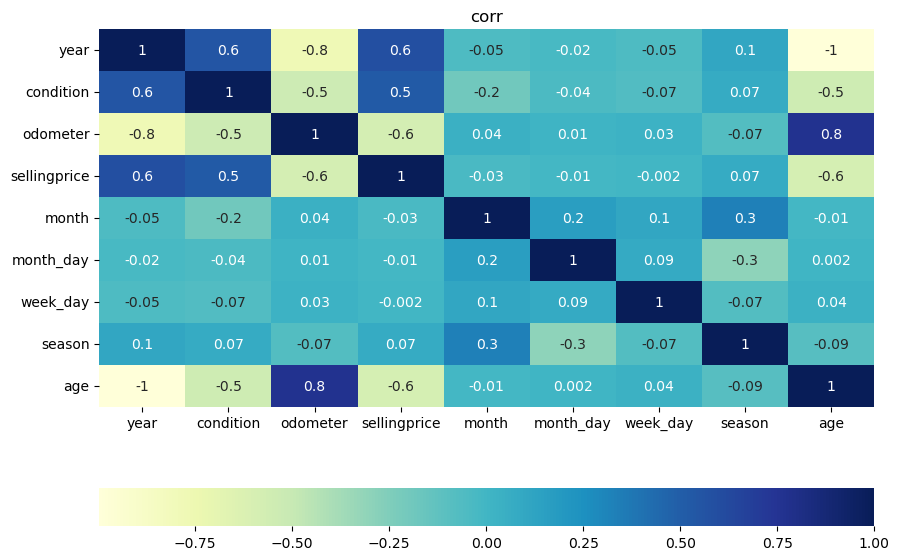

In [38]:
# Построим тепловую карту
plt.figure(figsize=(10, 7))
df_plot = sns.heatmap(df_corr.corr(), cmap="YlGnBu", annot=True, fmt='.1g',
                     cbar_kws= {'orientation': 'horizontal'})
plt.title('corr')
plt.show()

In [39]:
# Удалим столбцы week_day, month_day, month, age, saledate из признаков
df_train.drop(['week_day', 'month_day', 'month', 'age', 'saledate'], axis=1, inplace=True)
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,vin_transmis,season,vin_sh
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,j,3,dk3jc4
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,h,1,6p0h75
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,a,3,ab6ap4


In [40]:
# Столбец vin сделаем индексом
df_train = df_train.set_index('vin')
df_train.head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,vin_transmis,season,vin_sh
vin,,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,j,3,dk3jc4
3fa6p0h75er208976,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,h,1,6p0h75
3n1ab6ap4cl698412,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,a,3,ab6ap4


### Общие выводы по подготовке данных <a id='2.3'></a>

Сформирован сбалансированный набор показателей для эффективного прогнозирования цены продажи автомобиля.

По результату корреляционного анализа, не выявлена зависимость цены продажи ни с одним из показателей даты кроме сезона.

Проверка данных на мультиколлинеарность показала наличие параметров с высоким уровнем пересекающейся корреляции. Снижение уровня мультиколлинеарности было достигнуто удалением следующих параметров: `week_day`, `month_day`, `month`, `age`. Кроме того, отсутствует необходимость в параметре `saledate`.

Для обеспечения однозначной идентификации автомобиля, показатель `vin` вынесен в индекс датасета.

## Обучение моделей <a id='3'></a>

### Пробразование категорий в число <a id='3.1'></a>

In [41]:
# Списки измнения категориальных параметров и добавления числовых
list_in = ['make', 'model', 'body', 'transmission',  'state', 'color', 'interior', 'seller', 'trim', 'vin_sh']
list_out_i = ['make_numi', 'model_numi', 'body_numi', 'transmission_numi',  'state_numi', 'color_numi', 'interior_numi', 'seller_numi', 'trim_numi', 'vin_sh_numi']
list_out_s = ['make_nums', 'model_nums', 'body_nums', 'transmission_nums',  'state_nums', 'color_nums', 'interior_nums', 'seller_nums', 'trim_nums', 'vin_sh_nums']
list_num = ['year', 'condition', 'odometer', 'sellingprice', 'season']

In [42]:
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_int
df_train_short = pd.DataFrame()

for i in range(len(list_in)):
    df_train_short[list_out_i[i]] = df_train[list_in[i]].apply(word_int)

for i in range(len(list_num)):
    df_train_short[list_num[i]] = df_train[list_num[i]]


In [43]:
df_train_short.head(3)

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,sellingprice,season
vin,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,1066,1014,703,4793,309,1536,1536,17831,641,1698,2011,4.2,111041.0,12500,3
3fa6p0h75er208976,1066,2316,1555,4793,331,1536,1536,23070,317,1431,2014,3.5,31034.0,14500,1
3n1ab6ap4cl698412,2270,2263,1555,4793,322,1536,1536,16910,1637,1715,2012,2.2,35619.0,9100,3


In [44]:
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_str
df_train_long = pd.DataFrame()

for i in range(len(list_in)):
    df_train_long[list_out_s[i]] = df_train[list_in[i]].apply(word_str)

for i in range(len(list_num)):
    df_train_long[list_num[i]] = df_train[list_num[i]]


In [45]:
df_train_long.head(3)

,make_nums,model_nums,body_nums,transmission_nums,state_nums,color_nums,interior_nums,seller_nums,trim_nums,vin_sh_nums,year,condition,odometer,sellingprice,season
vin,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,102222342400,101200309404,115234354,97234348444545582812840891,109200,98216291396535,98216291396535,1151943304644856607008081026320108913321430161...,115202324,100214153424495312,2011,4.2,111041.0,12500,3
3fa6p0h75er208976,102222342400,102234345420555660,115202300388550,97234348444545582812840891,109222,98216291396535,98216291396535,9722834518848570873592028898012871200133914141...,115202,54224144416275318,2014,3.5,31034.0,14500,1
3n1ab6ap4cl698412,110210345460485660,115202330464570582,115202300388550,97234348444545582812840891,110212,98216291396535,98216291396535,1102103454604856603158409901020115513201365162...,5092144128575648,97196162388560312,2012,2.2,35619.0,9100,3


### Проверка метода word_str. Объединение значений символов <a id='3.2'></a>

In [46]:
# Разделим таблицу на признаки и целевые результаты
features_long = df_train_long.drop(['sellingprice'], axis=1)
target_long = df_train_long['sellingprice']

display(features_long.head(3))

,make_nums,model_nums,body_nums,transmission_nums,state_nums,color_nums,interior_nums,seller_nums,trim_nums,vin_sh_nums,year,condition,odometer,season
vin,,,,,,,,,,,,,,
2fmdk3jc4bba41556,102222342400,101200309404,115234354,97234348444545582812840891,109200,98216291396535,98216291396535,1151943304644856607008081026320108913321430161...,115202324,100214153424495312,2011,4.2,111041.0,3
3fa6p0h75er208976,102222342400,102234345420555660,115202300388550,97234348444545582812840891,109222,98216291396535,98216291396535,9722834518848570873592028898012871200133914141...,115202,54224144416275318,2014,3.5,31034.0,1
3n1ab6ap4cl698412,110210345460485660,115202330464570582,115202300388550,97234348444545582812840891,110212,98216291396535,98216291396535,1102103454604856603158409901020115513201365162...,5092144128575648,97196162388560312,2012,2.2,35619.0,3


In [47]:
# Разделим данные на обучающую и тестовую выборки

features_train_l, features_test_l, target_train_l, target_test_l = train_test_split(features_long, target_long,
                                                                            test_size=.25,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train_l.shape}')
print(f'Обучающая выборка целевого признака - {target_train_l.shape}')
print(f'Тестовая выборка признаков - {features_test_l.shape}')
print(f'Тестовая выборка целевого признака - {target_test_l.shape}')

Обучающая выборка признаков - (330177, 14)
Обучающая выборка целевого признака - (330177,)
Тестовая выборка признаков - (110059, 14)
Тестовая выборка целевого признака - (110059,)


In [48]:
# Проверим качество метода на лмнейной регрессии
model_regr_long = LinearRegression()
model_regr_long.fit(features_train_l, target_train_l)
answer_regr_long = model_regr_long.predict(features_test_l)
mape_model_regr_long = mean_absolute_percentage_error(target_test_l, answer_regr_long)
print(f'MAPE на регрессии с преобразованием категорий объединением - {mape_model_regr_long:.4f}')

MAPE на регрессии с преобразованием категорий объединением - 1.9559


**Вывод**

Качество прогноза очень низкое, поэтому отвергаем метод преобразования word_str

### Проверка метода word_int. Сумма значений символов <a id='3.3'></a>

In [50]:
# Разделим таблицу на признаки и целевые результаты
features_short = df_train_short.drop(['sellingprice'], axis=1)
target_short = df_train_short['sellingprice']

display(features_short.head(3))

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,season
vin,,,,,,,,,,,,,,
2fmdk3jc4bba41556,1066,1014,703,4793,309,1536,1536,17831,641,1698,2011,4.2,111041.0,3
3fa6p0h75er208976,1066,2316,1555,4793,331,1536,1536,23070,317,1431,2014,3.5,31034.0,1
3n1ab6ap4cl698412,2270,2263,1555,4793,322,1536,1536,16910,1637,1715,2012,2.2,35619.0,3


In [51]:
# Разделим данные на обучающую и тестовую выборки

features_train_s, features_test_s, target_train_s, target_test_s = train_test_split(features_short, target_short,
                                                                            test_size=.25,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train_s.shape}')
print(f'Обучающая выборка целевого признака - {target_train_s.shape}')
print(f'Тестовая выборка признаков - {features_test_s.shape}')
print(f'Тестовая выборка целевого признака - {target_test_s.shape}')

Обучающая выборка признаков - (330177, 14)
Обучающая выборка целевого признака - (330177,)
Тестовая выборка признаков - (110059, 14)
Тестовая выборка целевого признака - (110059,)


In [52]:
# Проведем стандартизацию данных

scaler = StandardScaler()
scaler.fit(features_train_s)
features_train_skaled = scaler.transform(features_train_s)
features_test_skaled = scaler.transform(features_test_s)

print(f'Обучающая стандартизированная выборка признаков - {features_train_skaled.shape}')
print(f'Тестовая стандартизированная выборка признаков - {features_test_skaled.shape}')

Обучающая стандартизированная выборка признаков - (330177, 14)
Тестовая стандартизированная выборка признаков - (110059, 14)


### Модель линейной регрессии <a id='3.4'></a>

**Модель линейной регрессии будет применена:**
- На исходной выборке
- На сокращенной выборке
- На стандартизированной  выборке

In [53]:
# Обучим модель линейной регрессии
model_regr_short = LinearRegression()
model_regr_short.fit(features_train_s, target_train_s)
answer_regr_short = model_regr_short.predict(features_test_s)
mape_model_regr_short = mean_absolute_percentage_error(target_test_s, answer_regr_short)
print(f'MAPE на регрессии с преобразованием категорий суммой - {mape_model_regr_short:.4f}')

MAPE на регрессии с преобразованием категорий суммой - 0.7038


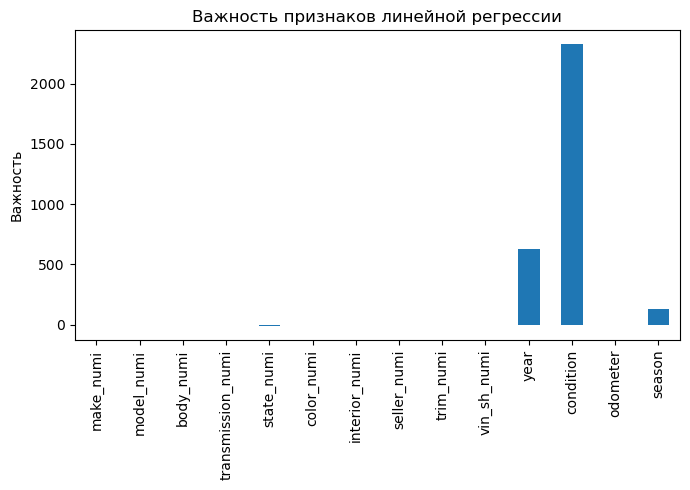

In [54]:
# Построим таблицу признаков линейной регрессии
coefs_reg = pd.DataFrame({
    'params': features_train_s.columns,
    'coef_reg': model_regr_short.coef_
})

# Постриои график признаков
fig, ax = plt.subplots(figsize=(7,5))
coefs_reg.plot.bar(ax=ax)
ax.set_title("Важность признаков линейной регрессии")
ax.set_ylabel('Важность')
ax.set_xticklabels(coefs_reg['params'])
ax.get_legend().remove()
fig.tight_layout()

In [55]:
# Для регрессии важны только три признака. 
# Изменим feature
features_train_s_reg = features_train_s[['year', 'condition', 'season']]
features_test_s_reg = features_test_s[['year', 'condition', 'season']]

print(f'Обучающая выборка признаков для регрессии - {features_train_s_reg.shape}')
print(f'Тестовая выборка признаков для регрессии - {features_test_s_reg.shape}')


Обучающая выборка признаков для регрессии - (330177, 3)
Тестовая выборка признаков для регрессии - (110059, 3)


In [56]:
# Обучим модель линейной регрессии на коротком датасете
model_regr_short_short = LinearRegression()
model_regr_short_short.fit(features_train_s_reg, target_train_s)
answer_regr_short_short = model_regr_short_short.predict(features_test_s_reg)
mape_model_regr_short_short = mean_absolute_percentage_error(target_test_s, answer_regr_short_short)
print(f'MAPE на регрессии на коротком датасете - {mape_model_regr_short_short:.4f}')

MAPE на регрессии на коротком датасете - 0.7302


In [57]:
# Обучим модель линейной регрессии на стандартизирванной выборке
model_regr_skaled = LinearRegression()
model_regr_skaled.fit(features_train_skaled, target_train_s)
answer_regr_skaled = model_regr_skaled.predict(features_test_skaled)
mape_model_regr_skaled = mean_absolute_percentage_error(target_test_s, answer_regr_skaled)
print(f'MAPE на регрессии на стандартизирванной выборке - {mape_model_regr_skaled:.4f}')

MAPE на регрессии на стандартизирванной выборке - 0.7038


### Модель Решающего дерева <a id='3.5'></a>

**Модель Решающего дерева будет применена:**
- На исходной выборке
- На сокращенной выборке
- На стандартизированной  выборке

In [58]:
# Обучим модель Решающего дерева
model_tree_short = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_short.fit(features_train_s, target_train_s)
answer_model_tree_short = model_tree_short.predict(features_test_s)
mape_model_tree_short = mean_absolute_percentage_error(target_test_s, answer_model_tree_short)
print(f'MAPE на дереве с преобразованием категорий суммой - {mape_model_tree_short:.4f}')

MAPE на дереве с преобразованием категорий суммой - 0.3538


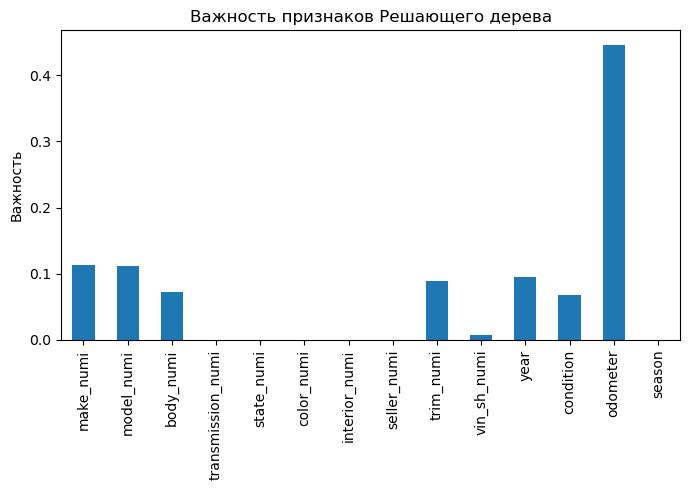

In [59]:
# Построим таблицу признаков Решающего дерева
coefs_tree = pd.DataFrame({
    'params': features_train_s.columns,
    'coef_tree': model_tree_short.feature_importances_
})

# Постриои график признаков
fig, ax = plt.subplots(figsize=(7,5))
coefs_tree.plot.bar(ax=ax)
ax.set_title("Важность признаков Решающего дерева")
ax.set_ylabel('Важность')
ax.set_xticklabels(coefs_tree['params'])
ax.get_legend().remove()
fig.tight_layout()

In [60]:
# Для Решающего дерева важны семь признаков.
# Изменим feature

features_train_s_tr = features_train_s[['make_numi', 'model_numi', 'body_numi', 'trim_numi', 'year', 'condition', 'odometer']]
features_test_s_tr = features_test_s[['make_numi', 'model_numi', 'body_numi', 'trim_numi', 'year', 'condition', 'odometer']]

print(f'Обучающая выборка признаков для Решающего дерева - {features_train_s_tr.shape}')
print(f'Тестовая выборка признаков для Решающего дерева - {features_test_s_tr.shape}')


Обучающая выборка признаков для Решающего дерева - (330177, 7)
Тестовая выборка признаков для Решающего дерева - (110059, 7)


In [61]:
# Обучим модель Решающего дерева на короткот датасете
model_tree_short_short = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_short_short.fit(features_train_s_tr, target_train_s)
answer_model_tree_short_short = model_tree_short_short.predict(features_test_s_tr)
mape_model_tree_short_short = mean_absolute_percentage_error(target_test_s, answer_model_tree_short_short)
print(f'MAPE на дереве на коротком датасете - {mape_model_tree_short_short:.4f}')

MAPE на дереве на коротком датасете - 0.3528


In [62]:
# Обучим модель Решающего дерева на стандартизирванной выборке
model_tree_skaled = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_skaled.fit(features_train_skaled, target_train_s)
answer_model_tree_skaled = model_tree_skaled.predict(features_test_skaled)
mape_model_tree_skaled = mean_absolute_percentage_error(target_test_s, answer_model_tree_skaled)
print(f'MAPE на дереве на стандартизирванной выборке - {mape_model_tree_skaled:.4f}')

MAPE на дереве на стандартизирванной выборке - 0.3537


### Методы улучшения качества моделей <a id='3.6'></a>

**Улучшение качества моделей:**
- с использованием кросс-валидации
- с подбором параметра Решающего дерева методом GridSearchCV
- с подбором числа деревьев Случайного леса 
- с использованием Фреймворка LightGBM
- с использованием Фреймворка CatBoost

In [63]:
# Обучим модель методом линейной регрессии с использованием кросс-валидация (3 частей)
line_regr_cross_valid_list = []
all_line = len(target_train_s)
sample_size = int(all_line//3.1)

for i in range(0, all_line, sample_size):
    if i+sample_size >= all_line:
        break
    else:
        valid_indexes = list(range(i, i+sample_size)) 
        train_indexes = list(range(0, i)) + list(range(i+sample_size, all_line))

        # Создадим выборки методом кросс-валидация и обучим модель
        features_train_short = features_train_s.loc[features_train_s.index[train_indexes]]
        target_train_short = target_train_s.loc[target_train_s.index[train_indexes]]
        features_valid_short = features_train_s.loc[features_train_s.index[valid_indexes]]
        target_valid_short = target_train_s.loc[target_train_s.index[valid_indexes]]
    
        model_line_regr_cross_valid = LinearRegression()
        model_line_regr_cross_valid.fit(features_train_short, target_train_short)
        predict_test = model_line_regr_cross_valid.predict(features_valid_short)

        # Проверим качество модели
        mape_test_short = mean_absolute_percentage_error(target_valid_short, predict_test)
        line_regr_cross_valid_list.append(mape_test_short)
    
# Рассчитаем среднее качество модели
fin_line_regr_cross_valid_list = sum(line_regr_cross_valid_list) / len(line_regr_cross_valid_list)
print(f'На модели логистической регрессии средний уровень MAPE = {fin_line_regr_cross_valid_list:.4f}')

answer_line_regr_cross_valid = model_line_regr_cross_valid.predict(features_test_s)
mape_model_line_regr_cross_valid = mean_absolute_percentage_error(target_test_s, answer_line_regr_cross_valid)

print(f"С использованем кросс-валидации точность модели по MAPE: {mape_model_line_regr_cross_valid:.4f}")


На модели логистической регрессии средний уровень MAPE = 0.7746
С использованем кросс-валидации точность модели по MAPE: 0.7039


In [64]:
# Подберем лучшие параметры Решающего дерева методом GridSearchCV
clf = DecisionTreeRegressor(random_state=state)
parametrs = {'max_depth': range(10, 26, 5)}

model_tree_regr = GridSearchCV(clf, parametrs, cv=3)
model_tree_regr.fit(features_train_s, target_train_s)
best_depth_tree_regr = model_tree_regr.best_params_.get('max_depth')
print(f'Лучший параметр глубины - {best_depth_tree_regr}')

# Обучим и проверим модель с подобранными параметрами
model_tree = DecisionTreeRegressor(max_depth=best_depth_tree_regr, random_state=state)
model_tree.fit(features_train_s, target_train_s)

answer_model_tree = model_tree.predict(features_test_s)
mape_model_tree = mean_absolute_percentage_error(target_test_s, answer_model_tree)

print(f"Точность модели Решающего дерева методом GridSearchCV по MAPE: {mape_model_tree:.4f}")


Лучший параметр глубины - 20
Точность модели Решающего дерева методом GridSearchCV по MAPE: 0.2315


In [65]:
# Улучшим модель Решающего дерева меняя число деревьев
best_result_forest = 1000
best_est_forest = 0
best_model_forest = 0
best_rmse_model_forest = 0

for est in range(10, 21, 10):
    model_forest = RandomForestRegressor(random_state=state,
                                   n_estimators=est, 
                                   max_depth=best_depth_tree_regr)
    model_forest.fit(features_train_s, target_train_s)
    predict_model_forest = model_forest.predict(features_test_s)
    test_model_forest = mean_absolute_percentage_error(target_test_s, predict_model_forest)
    
    if best_result_forest > test_model_forest:
        best_result_forest = test_model_forest
        best_est_forest = est
        best_model_forest = model_forest
        best_mape_model_forest = test_model_forest
print(f'Лучший параметр числа деревьев - {best_est_forest}')

answer_model_forest = best_model_forest.predict(features_test_s)
mape_model_forest = mean_absolute_percentage_error(target_test_s, answer_model_forest)

print(f"Точность модели Случайного леса по MAPE: {mape_model_forest:.4f}")


Лучший параметр числа деревьев - 20
Точность модели Случайного леса по MAPE: 0.1963


In [66]:
# Создадим модель с использованием Фреймворка LightGBM
lgb_model = lgb.LGBMModel(objective="regression", n_estimators=3000)
lgb_model.fit(features_train_s, target_train_s, eval_set=[(features_test_s, target_test_s),], eval_metric="mape")

answerr_lgb_model = lgb_model.predict(features_test_s)
mape_lgb_model = mean_absolute_percentage_error(target_test_s, answerr_lgb_model)

print(f"Точность модели LightGBM по MAPE: {mape_lgb_model:.4f}")


[1]	valid_0's mape: 1.6835	valid_0's l2: 8.50249e+07
[2]	valid_0's mape: 1.5609	valid_0's l2: 7.58428e+07
[3]	valid_0's mape: 1.45304	valid_0's l2: 6.88377e+07
[4]	valid_0's mape: 1.35422	valid_0's l2: 6.27453e+07
[5]	valid_0's mape: 1.26561	valid_0's l2: 5.76424e+07
[6]	valid_0's mape: 1.18176	valid_0's l2: 5.28876e+07
[7]	valid_0's mape: 1.11109	valid_0's l2: 4.91167e+07
[8]	valid_0's mape: 1.04735	valid_0's l2: 4.59453e+07
[9]	valid_0's mape: 0.984808	valid_0's l2: 4.30148e+07
[10]	valid_0's mape: 0.930317	valid_0's l2: 4.05275e+07
[11]	valid_0's mape: 0.881319	valid_0's l2: 3.84868e+07
[12]	valid_0's mape: 0.837726	valid_0's l2: 3.64082e+07
[13]	valid_0's mape: 0.80121	valid_0's l2: 3.44923e+07
[14]	valid_0's mape: 0.762607	valid_0's l2: 3.30509e+07
[15]	valid_0's mape: 0.723688	valid_0's l2: 3.17351e+07
[16]	valid_0's mape: 0.692866	valid_0's l2: 3.07168e+07
[17]	valid_0's mape: 0.666339	valid_0's l2: 2.9585e+07
[18]	valid_0's mape: 0.641007	valid_0's l2: 2.85599e+07
[19]	valid_0'

[150]	valid_0's mape: 0.237765	valid_0's l2: 8.9147e+06
[151]	valid_0's mape: 0.237604	valid_0's l2: 8.89826e+06
[152]	valid_0's mape: 0.237086	valid_0's l2: 8.84796e+06
[153]	valid_0's mape: 0.236736	valid_0's l2: 8.81033e+06
[154]	valid_0's mape: 0.235854	valid_0's l2: 8.79099e+06
[155]	valid_0's mape: 0.235712	valid_0's l2: 8.77255e+06
[156]	valid_0's mape: 0.235641	valid_0's l2: 8.75281e+06
[157]	valid_0's mape: 0.235523	valid_0's l2: 8.72869e+06
[158]	valid_0's mape: 0.235445	valid_0's l2: 8.71344e+06
[159]	valid_0's mape: 0.235391	valid_0's l2: 8.69755e+06
[160]	valid_0's mape: 0.234944	valid_0's l2: 8.67506e+06
[161]	valid_0's mape: 0.234733	valid_0's l2: 8.65766e+06
[162]	valid_0's mape: 0.234249	valid_0's l2: 8.64524e+06
[163]	valid_0's mape: 0.233919	valid_0's l2: 8.6365e+06
[164]	valid_0's mape: 0.233678	valid_0's l2: 8.59314e+06
[165]	valid_0's mape: 0.233455	valid_0's l2: 8.55859e+06
[166]	valid_0's mape: 0.23336	valid_0's l2: 8.53118e+06
[167]	valid_0's mape: 0.233182	val

[295]	valid_0's mape: 0.212701	valid_0's l2: 6.79446e+06
[296]	valid_0's mape: 0.212636	valid_0's l2: 6.78883e+06
[297]	valid_0's mape: 0.212438	valid_0's l2: 6.76732e+06
[298]	valid_0's mape: 0.212332	valid_0's l2: 6.76162e+06
[299]	valid_0's mape: 0.212215	valid_0's l2: 6.75498e+06
[300]	valid_0's mape: 0.212033	valid_0's l2: 6.74272e+06
[301]	valid_0's mape: 0.211882	valid_0's l2: 6.73684e+06
[302]	valid_0's mape: 0.211823	valid_0's l2: 6.73317e+06
[303]	valid_0's mape: 0.211787	valid_0's l2: 6.72979e+06
[304]	valid_0's mape: 0.211721	valid_0's l2: 6.72639e+06
[305]	valid_0's mape: 0.211693	valid_0's l2: 6.72432e+06
[306]	valid_0's mape: 0.211615	valid_0's l2: 6.71422e+06
[307]	valid_0's mape: 0.211335	valid_0's l2: 6.70615e+06
[308]	valid_0's mape: 0.211227	valid_0's l2: 6.70359e+06
[309]	valid_0's mape: 0.211188	valid_0's l2: 6.70134e+06
[310]	valid_0's mape: 0.211147	valid_0's l2: 6.68982e+06
[311]	valid_0's mape: 0.211154	valid_0's l2: 6.67679e+06
[312]	valid_0's mape: 0.21085	v

[445]	valid_0's mape: 0.199668	valid_0's l2: 6.02747e+06
[446]	valid_0's mape: 0.199639	valid_0's l2: 6.02584e+06
[447]	valid_0's mape: 0.19963	valid_0's l2: 6.02182e+06
[448]	valid_0's mape: 0.19954	valid_0's l2: 6.02017e+06
[449]	valid_0's mape: 0.199523	valid_0's l2: 6.01573e+06
[450]	valid_0's mape: 0.199388	valid_0's l2: 6.01075e+06
[451]	valid_0's mape: 0.199404	valid_0's l2: 6.01e+06
[452]	valid_0's mape: 0.199321	valid_0's l2: 6.00542e+06
[453]	valid_0's mape: 0.19927	valid_0's l2: 6.00292e+06
[454]	valid_0's mape: 0.198991	valid_0's l2: 5.99942e+06
[455]	valid_0's mape: 0.198788	valid_0's l2: 5.98088e+06
[456]	valid_0's mape: 0.198682	valid_0's l2: 5.97545e+06
[457]	valid_0's mape: 0.19855	valid_0's l2: 5.97141e+06
[458]	valid_0's mape: 0.198443	valid_0's l2: 5.96585e+06
[459]	valid_0's mape: 0.198317	valid_0's l2: 5.9617e+06
[460]	valid_0's mape: 0.198217	valid_0's l2: 5.95898e+06
[461]	valid_0's mape: 0.198172	valid_0's l2: 5.95723e+06
[462]	valid_0's mape: 0.198118	valid_0'

[597]	valid_0's mape: 0.191061	valid_0's l2: 5.55255e+06
[598]	valid_0's mape: 0.191055	valid_0's l2: 5.5512e+06
[599]	valid_0's mape: 0.191042	valid_0's l2: 5.54912e+06
[600]	valid_0's mape: 0.190996	valid_0's l2: 5.54667e+06
[601]	valid_0's mape: 0.190924	valid_0's l2: 5.54517e+06
[602]	valid_0's mape: 0.190925	valid_0's l2: 5.54364e+06
[603]	valid_0's mape: 0.190933	valid_0's l2: 5.54203e+06
[604]	valid_0's mape: 0.190886	valid_0's l2: 5.54163e+06
[605]	valid_0's mape: 0.190877	valid_0's l2: 5.53957e+06
[606]	valid_0's mape: 0.190878	valid_0's l2: 5.53907e+06
[607]	valid_0's mape: 0.190822	valid_0's l2: 5.53746e+06
[608]	valid_0's mape: 0.190766	valid_0's l2: 5.53469e+06
[609]	valid_0's mape: 0.190758	valid_0's l2: 5.53185e+06
[610]	valid_0's mape: 0.190684	valid_0's l2: 5.5275e+06
[611]	valid_0's mape: 0.190648	valid_0's l2: 5.52685e+06
[612]	valid_0's mape: 0.190647	valid_0's l2: 5.5252e+06
[613]	valid_0's mape: 0.190499	valid_0's l2: 5.52398e+06
[614]	valid_0's mape: 0.190447	val

[749]	valid_0's mape: 0.186098	valid_0's l2: 5.27824e+06
[750]	valid_0's mape: 0.186066	valid_0's l2: 5.27678e+06
[751]	valid_0's mape: 0.186001	valid_0's l2: 5.27479e+06
[752]	valid_0's mape: 0.185949	valid_0's l2: 5.27312e+06
[753]	valid_0's mape: 0.185916	valid_0's l2: 5.27192e+06
[754]	valid_0's mape: 0.185884	valid_0's l2: 5.27006e+06
[755]	valid_0's mape: 0.185867	valid_0's l2: 5.26762e+06
[756]	valid_0's mape: 0.185849	valid_0's l2: 5.26685e+06
[757]	valid_0's mape: 0.185814	valid_0's l2: 5.26598e+06
[758]	valid_0's mape: 0.185766	valid_0's l2: 5.26261e+06
[759]	valid_0's mape: 0.185756	valid_0's l2: 5.26021e+06
[760]	valid_0's mape: 0.185747	valid_0's l2: 5.25948e+06
[761]	valid_0's mape: 0.185683	valid_0's l2: 5.25756e+06
[762]	valid_0's mape: 0.185672	valid_0's l2: 5.25631e+06
[763]	valid_0's mape: 0.185586	valid_0's l2: 5.25419e+06
[764]	valid_0's mape: 0.185546	valid_0's l2: 5.25273e+06
[765]	valid_0's mape: 0.185522	valid_0's l2: 5.25162e+06
[766]	valid_0's mape: 0.18551	v

[899]	valid_0's mape: 0.18176	valid_0's l2: 5.02707e+06
[900]	valid_0's mape: 0.181758	valid_0's l2: 5.02675e+06
[901]	valid_0's mape: 0.181754	valid_0's l2: 5.02487e+06
[902]	valid_0's mape: 0.18173	valid_0's l2: 5.02377e+06
[903]	valid_0's mape: 0.181736	valid_0's l2: 5.02326e+06
[904]	valid_0's mape: 0.18172	valid_0's l2: 5.0227e+06
[905]	valid_0's mape: 0.181718	valid_0's l2: 5.02256e+06
[906]	valid_0's mape: 0.18171	valid_0's l2: 5.02179e+06
[907]	valid_0's mape: 0.181675	valid_0's l2: 5.01962e+06
[908]	valid_0's mape: 0.18166	valid_0's l2: 5.01911e+06
[909]	valid_0's mape: 0.181674	valid_0's l2: 5.01822e+06
[910]	valid_0's mape: 0.181673	valid_0's l2: 5.018e+06
[911]	valid_0's mape: 0.181567	valid_0's l2: 5.01426e+06
[912]	valid_0's mape: 0.181544	valid_0's l2: 5.01264e+06
[913]	valid_0's mape: 0.181546	valid_0's l2: 5.01169e+06
[914]	valid_0's mape: 0.181455	valid_0's l2: 5.01083e+06
[915]	valid_0's mape: 0.181451	valid_0's l2: 5.01036e+06
[916]	valid_0's mape: 0.181392	valid_0'

[1051]	valid_0's mape: 0.178249	valid_0's l2: 4.86073e+06
[1052]	valid_0's mape: 0.178249	valid_0's l2: 4.86026e+06
[1053]	valid_0's mape: 0.17824	valid_0's l2: 4.85929e+06
[1054]	valid_0's mape: 0.178224	valid_0's l2: 4.85801e+06
[1055]	valid_0's mape: 0.178219	valid_0's l2: 4.8578e+06
[1056]	valid_0's mape: 0.178199	valid_0's l2: 4.85485e+06
[1057]	valid_0's mape: 0.178165	valid_0's l2: 4.85442e+06
[1058]	valid_0's mape: 0.178169	valid_0's l2: 4.8518e+06
[1059]	valid_0's mape: 0.178139	valid_0's l2: 4.85e+06
[1060]	valid_0's mape: 0.178143	valid_0's l2: 4.84933e+06
[1061]	valid_0's mape: 0.17814	valid_0's l2: 4.84842e+06
[1062]	valid_0's mape: 0.178128	valid_0's l2: 4.84828e+06
[1063]	valid_0's mape: 0.17811	valid_0's l2: 4.84792e+06
[1064]	valid_0's mape: 0.178084	valid_0's l2: 4.84722e+06
[1065]	valid_0's mape: 0.178063	valid_0's l2: 4.84724e+06
[1066]	valid_0's mape: 0.178002	valid_0's l2: 4.84672e+06
[1067]	valid_0's mape: 0.177981	valid_0's l2: 4.84632e+06
[1068]	valid_0's mape:

[1199]	valid_0's mape: 0.176044	valid_0's l2: 4.72961e+06
[1200]	valid_0's mape: 0.176036	valid_0's l2: 4.72876e+06
[1201]	valid_0's mape: 0.176008	valid_0's l2: 4.72686e+06
[1202]	valid_0's mape: 0.176012	valid_0's l2: 4.72658e+06
[1203]	valid_0's mape: 0.175969	valid_0's l2: 4.72404e+06
[1204]	valid_0's mape: 0.175968	valid_0's l2: 4.72395e+06
[1205]	valid_0's mape: 0.175949	valid_0's l2: 4.72327e+06
[1206]	valid_0's mape: 0.175915	valid_0's l2: 4.72194e+06
[1207]	valid_0's mape: 0.175888	valid_0's l2: 4.72087e+06
[1208]	valid_0's mape: 0.175895	valid_0's l2: 4.72107e+06
[1209]	valid_0's mape: 0.175895	valid_0's l2: 4.72075e+06
[1210]	valid_0's mape: 0.175851	valid_0's l2: 4.71939e+06
[1211]	valid_0's mape: 0.17586	valid_0's l2: 4.71816e+06
[1212]	valid_0's mape: 0.175849	valid_0's l2: 4.71773e+06
[1213]	valid_0's mape: 0.17585	valid_0's l2: 4.71784e+06
[1214]	valid_0's mape: 0.175808	valid_0's l2: 4.71629e+06
[1215]	valid_0's mape: 0.175803	valid_0's l2: 4.71604e+06
[1216]	valid_0's

[1341]	valid_0's mape: 0.174003	valid_0's l2: 4.62163e+06
[1342]	valid_0's mape: 0.173983	valid_0's l2: 4.62063e+06
[1343]	valid_0's mape: 0.173977	valid_0's l2: 4.62077e+06
[1344]	valid_0's mape: 0.173972	valid_0's l2: 4.62034e+06
[1345]	valid_0's mape: 0.173966	valid_0's l2: 4.62018e+06
[1346]	valid_0's mape: 0.173966	valid_0's l2: 4.62002e+06
[1347]	valid_0's mape: 0.173964	valid_0's l2: 4.61957e+06
[1348]	valid_0's mape: 0.173963	valid_0's l2: 4.61947e+06
[1349]	valid_0's mape: 0.173965	valid_0's l2: 4.61952e+06
[1350]	valid_0's mape: 0.173951	valid_0's l2: 4.61923e+06
[1351]	valid_0's mape: 0.173959	valid_0's l2: 4.61889e+06
[1352]	valid_0's mape: 0.173959	valid_0's l2: 4.61892e+06
[1353]	valid_0's mape: 0.173922	valid_0's l2: 4.61883e+06
[1354]	valid_0's mape: 0.173916	valid_0's l2: 4.61857e+06
[1355]	valid_0's mape: 0.173899	valid_0's l2: 4.61768e+06
[1356]	valid_0's mape: 0.173888	valid_0's l2: 4.61695e+06
[1357]	valid_0's mape: 0.173889	valid_0's l2: 4.61687e+06
[1358]	valid_0

[1487]	valid_0's mape: 0.172202	valid_0's l2: 4.54677e+06
[1488]	valid_0's mape: 0.172115	valid_0's l2: 4.5457e+06
[1489]	valid_0's mape: 0.172096	valid_0's l2: 4.54547e+06
[1490]	valid_0's mape: 0.172104	valid_0's l2: 4.54543e+06
[1491]	valid_0's mape: 0.172078	valid_0's l2: 4.54263e+06
[1492]	valid_0's mape: 0.172046	valid_0's l2: 4.54207e+06
[1493]	valid_0's mape: 0.172043	valid_0's l2: 4.54088e+06
[1494]	valid_0's mape: 0.172029	valid_0's l2: 4.5408e+06
[1495]	valid_0's mape: 0.172016	valid_0's l2: 4.54061e+06
[1496]	valid_0's mape: 0.17201	valid_0's l2: 4.53963e+06
[1497]	valid_0's mape: 0.17201	valid_0's l2: 4.53947e+06
[1498]	valid_0's mape: 0.171995	valid_0's l2: 4.5391e+06
[1499]	valid_0's mape: 0.17199	valid_0's l2: 4.53854e+06
[1500]	valid_0's mape: 0.171981	valid_0's l2: 4.53812e+06
[1501]	valid_0's mape: 0.171969	valid_0's l2: 4.53767e+06
[1502]	valid_0's mape: 0.171968	valid_0's l2: 4.53701e+06
[1503]	valid_0's mape: 0.171963	valid_0's l2: 4.5367e+06
[1504]	valid_0's mape

[1633]	valid_0's mape: 0.17072	valid_0's l2: 4.47486e+06
[1634]	valid_0's mape: 0.170721	valid_0's l2: 4.4748e+06
[1635]	valid_0's mape: 0.170672	valid_0's l2: 4.47346e+06
[1636]	valid_0's mape: 0.170667	valid_0's l2: 4.47339e+06
[1637]	valid_0's mape: 0.170641	valid_0's l2: 4.47328e+06
[1638]	valid_0's mape: 0.170625	valid_0's l2: 4.47289e+06
[1639]	valid_0's mape: 0.170631	valid_0's l2: 4.47284e+06
[1640]	valid_0's mape: 0.170617	valid_0's l2: 4.47213e+06
[1641]	valid_0's mape: 0.170616	valid_0's l2: 4.47138e+06
[1642]	valid_0's mape: 0.170614	valid_0's l2: 4.4714e+06
[1643]	valid_0's mape: 0.170549	valid_0's l2: 4.47065e+06
[1644]	valid_0's mape: 0.170545	valid_0's l2: 4.47032e+06
[1645]	valid_0's mape: 0.170536	valid_0's l2: 4.46974e+06
[1646]	valid_0's mape: 0.170543	valid_0's l2: 4.46966e+06
[1647]	valid_0's mape: 0.17054	valid_0's l2: 4.46968e+06
[1648]	valid_0's mape: 0.170533	valid_0's l2: 4.46962e+06
[1649]	valid_0's mape: 0.170527	valid_0's l2: 4.46935e+06
[1650]	valid_0's m

[1776]	valid_0's mape: 0.169543	valid_0's l2: 4.41632e+06
[1777]	valid_0's mape: 0.169542	valid_0's l2: 4.41595e+06
[1778]	valid_0's mape: 0.169541	valid_0's l2: 4.416e+06
[1779]	valid_0's mape: 0.169513	valid_0's l2: 4.41528e+06
[1780]	valid_0's mape: 0.169491	valid_0's l2: 4.41509e+06
[1781]	valid_0's mape: 0.16948	valid_0's l2: 4.415e+06
[1782]	valid_0's mape: 0.169481	valid_0's l2: 4.41494e+06
[1783]	valid_0's mape: 0.169484	valid_0's l2: 4.41483e+06
[1784]	valid_0's mape: 0.169474	valid_0's l2: 4.4146e+06
[1785]	valid_0's mape: 0.169399	valid_0's l2: 4.41378e+06
[1786]	valid_0's mape: 0.169381	valid_0's l2: 4.41275e+06
[1787]	valid_0's mape: 0.169369	valid_0's l2: 4.41256e+06
[1788]	valid_0's mape: 0.169371	valid_0's l2: 4.41206e+06
[1789]	valid_0's mape: 0.169362	valid_0's l2: 4.41087e+06
[1790]	valid_0's mape: 0.169361	valid_0's l2: 4.41078e+06
[1791]	valid_0's mape: 0.169363	valid_0's l2: 4.41067e+06
[1792]	valid_0's mape: 0.169359	valid_0's l2: 4.40936e+06
[1793]	valid_0's map

[1924]	valid_0's mape: 0.168382	valid_0's l2: 4.35938e+06
[1925]	valid_0's mape: 0.168375	valid_0's l2: 4.35904e+06
[1926]	valid_0's mape: 0.168383	valid_0's l2: 4.35905e+06
[1927]	valid_0's mape: 0.168379	valid_0's l2: 4.35888e+06
[1928]	valid_0's mape: 0.168374	valid_0's l2: 4.35889e+06
[1929]	valid_0's mape: 0.168361	valid_0's l2: 4.3588e+06
[1930]	valid_0's mape: 0.168358	valid_0's l2: 4.35873e+06
[1931]	valid_0's mape: 0.168343	valid_0's l2: 4.35837e+06
[1932]	valid_0's mape: 0.168342	valid_0's l2: 4.35828e+06
[1933]	valid_0's mape: 0.168346	valid_0's l2: 4.35841e+06
[1934]	valid_0's mape: 0.168367	valid_0's l2: 4.3583e+06
[1935]	valid_0's mape: 0.168332	valid_0's l2: 4.35776e+06
[1936]	valid_0's mape: 0.168329	valid_0's l2: 4.3577e+06
[1937]	valid_0's mape: 0.168327	valid_0's l2: 4.35773e+06
[1938]	valid_0's mape: 0.168318	valid_0's l2: 4.35738e+06
[1939]	valid_0's mape: 0.168292	valid_0's l2: 4.35686e+06
[1940]	valid_0's mape: 0.168256	valid_0's l2: 4.35661e+06
[1941]	valid_0's 

[2073]	valid_0's mape: 0.167126	valid_0's l2: 4.32164e+06
[2074]	valid_0's mape: 0.167111	valid_0's l2: 4.32144e+06
[2075]	valid_0's mape: 0.167104	valid_0's l2: 4.32113e+06
[2076]	valid_0's mape: 0.167093	valid_0's l2: 4.32085e+06
[2077]	valid_0's mape: 0.167061	valid_0's l2: 4.32042e+06
[2078]	valid_0's mape: 0.167047	valid_0's l2: 4.31961e+06
[2079]	valid_0's mape: 0.167034	valid_0's l2: 4.31921e+06
[2080]	valid_0's mape: 0.16702	valid_0's l2: 4.31903e+06
[2081]	valid_0's mape: 0.167023	valid_0's l2: 4.31883e+06
[2082]	valid_0's mape: 0.167023	valid_0's l2: 4.3189e+06
[2083]	valid_0's mape: 0.167022	valid_0's l2: 4.31893e+06
[2084]	valid_0's mape: 0.167005	valid_0's l2: 4.31864e+06
[2085]	valid_0's mape: 0.167	valid_0's l2: 4.31853e+06
[2086]	valid_0's mape: 0.166988	valid_0's l2: 4.31851e+06
[2087]	valid_0's mape: 0.16698	valid_0's l2: 4.31824e+06
[2088]	valid_0's mape: 0.166968	valid_0's l2: 4.31811e+06
[2089]	valid_0's mape: 0.166962	valid_0's l2: 4.31763e+06
[2090]	valid_0's map

[2218]	valid_0's mape: 0.165813	valid_0's l2: 4.28342e+06
[2219]	valid_0's mape: 0.165815	valid_0's l2: 4.28342e+06
[2220]	valid_0's mape: 0.165813	valid_0's l2: 4.28344e+06
[2221]	valid_0's mape: 0.165787	valid_0's l2: 4.28283e+06
[2222]	valid_0's mape: 0.165772	valid_0's l2: 4.28189e+06
[2223]	valid_0's mape: 0.165755	valid_0's l2: 4.27997e+06
[2224]	valid_0's mape: 0.165734	valid_0's l2: 4.27949e+06
[2225]	valid_0's mape: 0.165732	valid_0's l2: 4.27923e+06
[2226]	valid_0's mape: 0.165698	valid_0's l2: 4.27882e+06
[2227]	valid_0's mape: 0.165697	valid_0's l2: 4.27861e+06
[2228]	valid_0's mape: 0.165695	valid_0's l2: 4.27851e+06
[2229]	valid_0's mape: 0.165686	valid_0's l2: 4.278e+06
[2230]	valid_0's mape: 0.165644	valid_0's l2: 4.27751e+06
[2231]	valid_0's mape: 0.165638	valid_0's l2: 4.277e+06
[2232]	valid_0's mape: 0.165643	valid_0's l2: 4.27689e+06
[2233]	valid_0's mape: 0.165647	valid_0's l2: 4.27701e+06
[2234]	valid_0's mape: 0.165628	valid_0's l2: 4.27681e+06
[2235]	valid_0's m

[2367]	valid_0's mape: 0.164929	valid_0's l2: 4.24945e+06
[2368]	valid_0's mape: 0.164921	valid_0's l2: 4.24863e+06
[2369]	valid_0's mape: 0.164916	valid_0's l2: 4.24863e+06
[2370]	valid_0's mape: 0.164914	valid_0's l2: 4.24866e+06
[2371]	valid_0's mape: 0.164912	valid_0's l2: 4.24856e+06
[2372]	valid_0's mape: 0.164901	valid_0's l2: 4.24859e+06
[2373]	valid_0's mape: 0.164882	valid_0's l2: 4.24835e+06
[2374]	valid_0's mape: 0.164878	valid_0's l2: 4.24749e+06
[2375]	valid_0's mape: 0.164876	valid_0's l2: 4.24732e+06
[2376]	valid_0's mape: 0.164873	valid_0's l2: 4.24708e+06
[2377]	valid_0's mape: 0.164871	valid_0's l2: 4.24704e+06
[2378]	valid_0's mape: 0.16487	valid_0's l2: 4.24698e+06
[2379]	valid_0's mape: 0.16487	valid_0's l2: 4.24698e+06
[2380]	valid_0's mape: 0.164872	valid_0's l2: 4.24699e+06
[2381]	valid_0's mape: 0.164876	valid_0's l2: 4.24696e+06
[2382]	valid_0's mape: 0.164854	valid_0's l2: 4.24678e+06
[2383]	valid_0's mape: 0.164842	valid_0's l2: 4.24661e+06
[2384]	valid_0's

[2518]	valid_0's mape: 0.16396	valid_0's l2: 4.22544e+06
[2519]	valid_0's mape: 0.163937	valid_0's l2: 4.22509e+06
[2520]	valid_0's mape: 0.163936	valid_0's l2: 4.22507e+06
[2521]	valid_0's mape: 0.163941	valid_0's l2: 4.22508e+06
[2522]	valid_0's mape: 0.163942	valid_0's l2: 4.22488e+06
[2523]	valid_0's mape: 0.163923	valid_0's l2: 4.22456e+06
[2524]	valid_0's mape: 0.163912	valid_0's l2: 4.2237e+06
[2525]	valid_0's mape: 0.163907	valid_0's l2: 4.22352e+06
[2526]	valid_0's mape: 0.163918	valid_0's l2: 4.22364e+06
[2527]	valid_0's mape: 0.163914	valid_0's l2: 4.22368e+06
[2528]	valid_0's mape: 0.163915	valid_0's l2: 4.22361e+06
[2529]	valid_0's mape: 0.163915	valid_0's l2: 4.22364e+06
[2530]	valid_0's mape: 0.163908	valid_0's l2: 4.22361e+06
[2531]	valid_0's mape: 0.163898	valid_0's l2: 4.22366e+06
[2532]	valid_0's mape: 0.163902	valid_0's l2: 4.22357e+06
[2533]	valid_0's mape: 0.163896	valid_0's l2: 4.22337e+06
[2534]	valid_0's mape: 0.163898	valid_0's l2: 4.22342e+06
[2535]	valid_0's

[2660]	valid_0's mape: 0.163347	valid_0's l2: 4.20387e+06
[2661]	valid_0's mape: 0.163338	valid_0's l2: 4.20374e+06
[2662]	valid_0's mape: 0.163333	valid_0's l2: 4.20359e+06
[2663]	valid_0's mape: 0.163344	valid_0's l2: 4.20312e+06
[2664]	valid_0's mape: 0.163339	valid_0's l2: 4.20301e+06
[2665]	valid_0's mape: 0.163327	valid_0's l2: 4.20279e+06
[2666]	valid_0's mape: 0.163308	valid_0's l2: 4.20272e+06
[2667]	valid_0's mape: 0.163308	valid_0's l2: 4.20257e+06
[2668]	valid_0's mape: 0.163309	valid_0's l2: 4.20256e+06
[2669]	valid_0's mape: 0.163318	valid_0's l2: 4.20261e+06
[2670]	valid_0's mape: 0.163313	valid_0's l2: 4.20274e+06
[2671]	valid_0's mape: 0.16331	valid_0's l2: 4.20265e+06
[2672]	valid_0's mape: 0.163303	valid_0's l2: 4.20237e+06
[2673]	valid_0's mape: 0.163304	valid_0's l2: 4.20237e+06
[2674]	valid_0's mape: 0.163296	valid_0's l2: 4.20211e+06
[2675]	valid_0's mape: 0.163301	valid_0's l2: 4.20214e+06
[2676]	valid_0's mape: 0.163293	valid_0's l2: 4.20204e+06
[2677]	valid_0'

[2810]	valid_0's mape: 0.16285	valid_0's l2: 4.18147e+06
[2811]	valid_0's mape: 0.162838	valid_0's l2: 4.18129e+06
[2812]	valid_0's mape: 0.162838	valid_0's l2: 4.1813e+06
[2813]	valid_0's mape: 0.162836	valid_0's l2: 4.18125e+06
[2814]	valid_0's mape: 0.162831	valid_0's l2: 4.1812e+06
[2815]	valid_0's mape: 0.162838	valid_0's l2: 4.18113e+06
[2816]	valid_0's mape: 0.162828	valid_0's l2: 4.18121e+06
[2817]	valid_0's mape: 0.162822	valid_0's l2: 4.18089e+06
[2818]	valid_0's mape: 0.162791	valid_0's l2: 4.18076e+06
[2819]	valid_0's mape: 0.162792	valid_0's l2: 4.1808e+06
[2820]	valid_0's mape: 0.162788	valid_0's l2: 4.18047e+06
[2821]	valid_0's mape: 0.162786	valid_0's l2: 4.1802e+06
[2822]	valid_0's mape: 0.162773	valid_0's l2: 4.17899e+06
[2823]	valid_0's mape: 0.162765	valid_0's l2: 4.17879e+06
[2824]	valid_0's mape: 0.162758	valid_0's l2: 4.17874e+06
[2825]	valid_0's mape: 0.162763	valid_0's l2: 4.1788e+06
[2826]	valid_0's mape: 0.162768	valid_0's l2: 4.17879e+06
[2827]	valid_0's map

[2952]	valid_0's mape: 0.162247	valid_0's l2: 4.16091e+06
[2953]	valid_0's mape: 0.162242	valid_0's l2: 4.16084e+06
[2954]	valid_0's mape: 0.162226	valid_0's l2: 4.16066e+06
[2955]	valid_0's mape: 0.162227	valid_0's l2: 4.16011e+06
[2956]	valid_0's mape: 0.162243	valid_0's l2: 4.16016e+06
[2957]	valid_0's mape: 0.162244	valid_0's l2: 4.16019e+06
[2958]	valid_0's mape: 0.162245	valid_0's l2: 4.15993e+06
[2959]	valid_0's mape: 0.162246	valid_0's l2: 4.15923e+06
[2960]	valid_0's mape: 0.162248	valid_0's l2: 4.15896e+06
[2961]	valid_0's mape: 0.162242	valid_0's l2: 4.15897e+06
[2962]	valid_0's mape: 0.162241	valid_0's l2: 4.15897e+06
[2963]	valid_0's mape: 0.162237	valid_0's l2: 4.15775e+06
[2964]	valid_0's mape: 0.162242	valid_0's l2: 4.15766e+06
[2965]	valid_0's mape: 0.162245	valid_0's l2: 4.15756e+06
[2966]	valid_0's mape: 0.162245	valid_0's l2: 4.15753e+06
[2967]	valid_0's mape: 0.162242	valid_0's l2: 4.15729e+06
[2968]	valid_0's mape: 0.162235	valid_0's l2: 4.15687e+06
[2969]	valid_0

In [67]:
# Создадим модель с использованием Фреймворка LightGBM на стандартизированных данных
lgb_model_skaled = lgb.LGBMModel(objective="regression", n_estimators=10000)
lgb_model_skaled.fit(features_train_skaled, target_train_s, eval_set=[(features_test_skaled, target_test_s),], eval_metric="mape")

answerr_lgb_model_skaled = lgb_model_skaled.predict(features_test_skaled)
mape_lgb_model_skaled = mean_absolute_percentage_error(target_test_s, answerr_lgb_model_skaled)

print(f"Точность модели LightGBM по MAPE: {mape_lgb_model_skaled:.4f}")

[1]	valid_0's mape: 1.6835	valid_0's l2: 8.50145e+07
[2]	valid_0's mape: 1.56095	valid_0's l2: 7.58269e+07
[3]	valid_0's mape: 1.45309	valid_0's l2: 6.88181e+07
[4]	valid_0's mape: 1.35428	valid_0's l2: 6.27243e+07
[5]	valid_0's mape: 1.26456	valid_0's l2: 5.75201e+07
[6]	valid_0's mape: 1.18032	valid_0's l2: 5.27818e+07
[7]	valid_0's mape: 1.1101	valid_0's l2: 4.90831e+07
[8]	valid_0's mape: 1.04483	valid_0's l2: 4.53486e+07
[9]	valid_0's mape: 0.987792	valid_0's l2: 4.25178e+07
[10]	valid_0's mape: 0.930708	valid_0's l2: 4.00915e+07
[11]	valid_0's mape: 0.88497	valid_0's l2: 3.76958e+07
[12]	valid_0's mape: 0.840029	valid_0's l2: 3.59534e+07
[13]	valid_0's mape: 0.797678	valid_0's l2: 3.41858e+07
[14]	valid_0's mape: 0.758561	valid_0's l2: 3.2849e+07
[15]	valid_0's mape: 0.723089	valid_0's l2: 3.16011e+07
[16]	valid_0's mape: 0.692944	valid_0's l2: 3.02572e+07
[17]	valid_0's mape: 0.662446	valid_0's l2: 2.93289e+07
[18]	valid_0's mape: 0.634198	valid_0's l2: 2.83882e+07
[19]	valid_0'

[154]	valid_0's mape: 0.236979	valid_0's l2: 8.59535e+06
[155]	valid_0's mape: 0.2365	valid_0's l2: 8.57812e+06
[156]	valid_0's mape: 0.236211	valid_0's l2: 8.53751e+06
[157]	valid_0's mape: 0.235928	valid_0's l2: 8.5269e+06
[158]	valid_0's mape: 0.235632	valid_0's l2: 8.4889e+06
[159]	valid_0's mape: 0.235302	valid_0's l2: 8.47321e+06
[160]	valid_0's mape: 0.235037	valid_0's l2: 8.45434e+06
[161]	valid_0's mape: 0.234676	valid_0's l2: 8.41604e+06
[162]	valid_0's mape: 0.234453	valid_0's l2: 8.40186e+06
[163]	valid_0's mape: 0.234148	valid_0's l2: 8.38579e+06
[164]	valid_0's mape: 0.233819	valid_0's l2: 8.34498e+06
[165]	valid_0's mape: 0.233605	valid_0's l2: 8.32099e+06
[166]	valid_0's mape: 0.233339	valid_0's l2: 8.29166e+06
[167]	valid_0's mape: 0.2333	valid_0's l2: 8.27277e+06
[168]	valid_0's mape: 0.233212	valid_0's l2: 8.25489e+06
[169]	valid_0's mape: 0.232988	valid_0's l2: 8.22907e+06
[170]	valid_0's mape: 0.232423	valid_0's l2: 8.21274e+06
[171]	valid_0's mape: 0.232386	valid_

[304]	valid_0's mape: 0.21082	valid_0's l2: 6.51849e+06
[305]	valid_0's mape: 0.210598	valid_0's l2: 6.50869e+06
[306]	valid_0's mape: 0.210547	valid_0's l2: 6.50423e+06
[307]	valid_0's mape: 0.210511	valid_0's l2: 6.50081e+06
[308]	valid_0's mape: 0.210455	valid_0's l2: 6.49473e+06
[309]	valid_0's mape: 0.210315	valid_0's l2: 6.48971e+06
[310]	valid_0's mape: 0.210207	valid_0's l2: 6.48538e+06
[311]	valid_0's mape: 0.209875	valid_0's l2: 6.47958e+06
[312]	valid_0's mape: 0.209724	valid_0's l2: 6.4669e+06
[313]	valid_0's mape: 0.209624	valid_0's l2: 6.46213e+06
[314]	valid_0's mape: 0.209557	valid_0's l2: 6.45745e+06
[315]	valid_0's mape: 0.209472	valid_0's l2: 6.45301e+06
[316]	valid_0's mape: 0.20945	valid_0's l2: 6.4498e+06
[317]	valid_0's mape: 0.209385	valid_0's l2: 6.44682e+06
[318]	valid_0's mape: 0.209348	valid_0's l2: 6.44246e+06
[319]	valid_0's mape: 0.209335	valid_0's l2: 6.43898e+06
[320]	valid_0's mape: 0.20916	valid_0's l2: 6.43527e+06
[321]	valid_0's mape: 0.209096	valid

[449]	valid_0's mape: 0.198766	valid_0's l2: 5.80396e+06
[450]	valid_0's mape: 0.198657	valid_0's l2: 5.79725e+06
[451]	valid_0's mape: 0.198394	valid_0's l2: 5.78816e+06
[452]	valid_0's mape: 0.198402	valid_0's l2: 5.78367e+06
[453]	valid_0's mape: 0.198344	valid_0's l2: 5.77991e+06
[454]	valid_0's mape: 0.198276	valid_0's l2: 5.7791e+06
[455]	valid_0's mape: 0.198271	valid_0's l2: 5.77744e+06
[456]	valid_0's mape: 0.198254	valid_0's l2: 5.7756e+06
[457]	valid_0's mape: 0.198032	valid_0's l2: 5.76568e+06
[458]	valid_0's mape: 0.197996	valid_0's l2: 5.76485e+06
[459]	valid_0's mape: 0.197993	valid_0's l2: 5.76453e+06
[460]	valid_0's mape: 0.197956	valid_0's l2: 5.76368e+06
[461]	valid_0's mape: 0.197808	valid_0's l2: 5.75482e+06
[462]	valid_0's mape: 0.19779	valid_0's l2: 5.75368e+06
[463]	valid_0's mape: 0.197762	valid_0's l2: 5.75121e+06
[464]	valid_0's mape: 0.197718	valid_0's l2: 5.74807e+06
[465]	valid_0's mape: 0.197706	valid_0's l2: 5.74418e+06
[466]	valid_0's mape: 0.197691	val

[596]	valid_0's mape: 0.19048	valid_0's l2: 5.35241e+06
[597]	valid_0's mape: 0.190456	valid_0's l2: 5.35132e+06
[598]	valid_0's mape: 0.190416	valid_0's l2: 5.34977e+06
[599]	valid_0's mape: 0.190379	valid_0's l2: 5.34483e+06
[600]	valid_0's mape: 0.190371	valid_0's l2: 5.34451e+06
[601]	valid_0's mape: 0.190351	valid_0's l2: 5.34341e+06
[602]	valid_0's mape: 0.190235	valid_0's l2: 5.34193e+06
[603]	valid_0's mape: 0.190246	valid_0's l2: 5.34156e+06
[604]	valid_0's mape: 0.1902	valid_0's l2: 5.34113e+06
[605]	valid_0's mape: 0.190079	valid_0's l2: 5.3344e+06
[606]	valid_0's mape: 0.190074	valid_0's l2: 5.32756e+06
[607]	valid_0's mape: 0.190049	valid_0's l2: 5.32678e+06
[608]	valid_0's mape: 0.190019	valid_0's l2: 5.32409e+06
[609]	valid_0's mape: 0.189981	valid_0's l2: 5.32308e+06
[610]	valid_0's mape: 0.189982	valid_0's l2: 5.3218e+06
[611]	valid_0's mape: 0.189924	valid_0's l2: 5.31789e+06
[612]	valid_0's mape: 0.189928	valid_0's l2: 5.31718e+06
[613]	valid_0's mape: 0.189905	valid

[747]	valid_0's mape: 0.184719	valid_0's l2: 5.04887e+06
[748]	valid_0's mape: 0.184705	valid_0's l2: 5.04843e+06
[749]	valid_0's mape: 0.184705	valid_0's l2: 5.04613e+06
[750]	valid_0's mape: 0.18469	valid_0's l2: 5.04432e+06
[751]	valid_0's mape: 0.184398	valid_0's l2: 5.04251e+06
[752]	valid_0's mape: 0.184389	valid_0's l2: 5.04157e+06
[753]	valid_0's mape: 0.184382	valid_0's l2: 5.04072e+06
[754]	valid_0's mape: 0.184341	valid_0's l2: 5.03871e+06
[755]	valid_0's mape: 0.184296	valid_0's l2: 5.03704e+06
[756]	valid_0's mape: 0.184258	valid_0's l2: 5.03467e+06
[757]	valid_0's mape: 0.18425	valid_0's l2: 5.03294e+06
[758]	valid_0's mape: 0.184201	valid_0's l2: 5.02967e+06
[759]	valid_0's mape: 0.184182	valid_0's l2: 5.02872e+06
[760]	valid_0's mape: 0.184133	valid_0's l2: 5.02647e+06
[761]	valid_0's mape: 0.184134	valid_0's l2: 5.02354e+06
[762]	valid_0's mape: 0.184142	valid_0's l2: 5.02353e+06
[763]	valid_0's mape: 0.184104	valid_0's l2: 5.02292e+06
[764]	valid_0's mape: 0.184053	va

[898]	valid_0's mape: 0.180217	valid_0's l2: 4.85499e+06
[899]	valid_0's mape: 0.18018	valid_0's l2: 4.85321e+06
[900]	valid_0's mape: 0.180134	valid_0's l2: 4.85267e+06
[901]	valid_0's mape: 0.18013	valid_0's l2: 4.85234e+06
[902]	valid_0's mape: 0.180141	valid_0's l2: 4.85185e+06
[903]	valid_0's mape: 0.180123	valid_0's l2: 4.85063e+06
[904]	valid_0's mape: 0.180128	valid_0's l2: 4.85034e+06
[905]	valid_0's mape: 0.180051	valid_0's l2: 4.85003e+06
[906]	valid_0's mape: 0.180054	valid_0's l2: 4.84669e+06
[907]	valid_0's mape: 0.18004	valid_0's l2: 4.84506e+06
[908]	valid_0's mape: 0.180019	valid_0's l2: 4.84451e+06
[909]	valid_0's mape: 0.180018	valid_0's l2: 4.84388e+06
[910]	valid_0's mape: 0.179998	valid_0's l2: 4.84334e+06
[911]	valid_0's mape: 0.179955	valid_0's l2: 4.84233e+06
[912]	valid_0's mape: 0.179953	valid_0's l2: 4.84204e+06
[913]	valid_0's mape: 0.179938	valid_0's l2: 4.84182e+06
[914]	valid_0's mape: 0.179933	valid_0's l2: 4.84192e+06
[915]	valid_0's mape: 0.179946	val

[1043]	valid_0's mape: 0.177437	valid_0's l2: 4.71144e+06
[1044]	valid_0's mape: 0.177432	valid_0's l2: 4.71104e+06
[1045]	valid_0's mape: 0.177441	valid_0's l2: 4.71076e+06
[1046]	valid_0's mape: 0.17744	valid_0's l2: 4.71025e+06
[1047]	valid_0's mape: 0.177445	valid_0's l2: 4.71021e+06
[1048]	valid_0's mape: 0.177424	valid_0's l2: 4.70946e+06
[1049]	valid_0's mape: 0.177399	valid_0's l2: 4.70858e+06
[1050]	valid_0's mape: 0.177395	valid_0's l2: 4.70753e+06
[1051]	valid_0's mape: 0.1774	valid_0's l2: 4.70733e+06
[1052]	valid_0's mape: 0.177397	valid_0's l2: 4.7072e+06
[1053]	valid_0's mape: 0.177348	valid_0's l2: 4.70658e+06
[1054]	valid_0's mape: 0.177341	valid_0's l2: 4.70588e+06
[1055]	valid_0's mape: 0.177335	valid_0's l2: 4.70495e+06
[1056]	valid_0's mape: 0.17734	valid_0's l2: 4.70469e+06
[1057]	valid_0's mape: 0.177332	valid_0's l2: 4.70344e+06
[1058]	valid_0's mape: 0.177333	valid_0's l2: 4.7032e+06
[1059]	valid_0's mape: 0.177328	valid_0's l2: 4.70285e+06
[1060]	valid_0's map

[1185]	valid_0's mape: 0.175283	valid_0's l2: 4.61382e+06
[1186]	valid_0's mape: 0.175268	valid_0's l2: 4.61264e+06
[1187]	valid_0's mape: 0.175266	valid_0's l2: 4.61248e+06
[1188]	valid_0's mape: 0.175241	valid_0's l2: 4.61168e+06
[1189]	valid_0's mape: 0.175222	valid_0's l2: 4.61112e+06
[1190]	valid_0's mape: 0.175204	valid_0's l2: 4.60972e+06
[1191]	valid_0's mape: 0.175156	valid_0's l2: 4.60897e+06
[1192]	valid_0's mape: 0.175153	valid_0's l2: 4.60885e+06
[1193]	valid_0's mape: 0.175142	valid_0's l2: 4.60791e+06
[1194]	valid_0's mape: 0.175098	valid_0's l2: 4.60595e+06
[1195]	valid_0's mape: 0.175068	valid_0's l2: 4.60514e+06
[1196]	valid_0's mape: 0.17507	valid_0's l2: 4.60474e+06
[1197]	valid_0's mape: 0.175057	valid_0's l2: 4.60365e+06
[1198]	valid_0's mape: 0.175055	valid_0's l2: 4.60272e+06
[1199]	valid_0's mape: 0.175055	valid_0's l2: 4.60275e+06
[1200]	valid_0's mape: 0.175047	valid_0's l2: 4.60256e+06
[1201]	valid_0's mape: 0.175032	valid_0's l2: 4.60148e+06
[1202]	valid_0'

[1331]	valid_0's mape: 0.173362	valid_0's l2: 4.52832e+06
[1332]	valid_0's mape: 0.173355	valid_0's l2: 4.52808e+06
[1333]	valid_0's mape: 0.173347	valid_0's l2: 4.52765e+06
[1334]	valid_0's mape: 0.173343	valid_0's l2: 4.52715e+06
[1335]	valid_0's mape: 0.173331	valid_0's l2: 4.52731e+06
[1336]	valid_0's mape: 0.173268	valid_0's l2: 4.52647e+06
[1337]	valid_0's mape: 0.173268	valid_0's l2: 4.52585e+06
[1338]	valid_0's mape: 0.173266	valid_0's l2: 4.5256e+06
[1339]	valid_0's mape: 0.173247	valid_0's l2: 4.52452e+06
[1340]	valid_0's mape: 0.173252	valid_0's l2: 4.52421e+06
[1341]	valid_0's mape: 0.173226	valid_0's l2: 4.52387e+06
[1342]	valid_0's mape: 0.173207	valid_0's l2: 4.52362e+06
[1343]	valid_0's mape: 0.173174	valid_0's l2: 4.52243e+06
[1344]	valid_0's mape: 0.173154	valid_0's l2: 4.52215e+06
[1345]	valid_0's mape: 0.173105	valid_0's l2: 4.52174e+06
[1346]	valid_0's mape: 0.173107	valid_0's l2: 4.52166e+06
[1347]	valid_0's mape: 0.173073	valid_0's l2: 4.52065e+06
[1348]	valid_0'

[1479]	valid_0's mape: 0.171584	valid_0's l2: 4.46223e+06
[1480]	valid_0's mape: 0.171578	valid_0's l2: 4.46167e+06
[1481]	valid_0's mape: 0.171582	valid_0's l2: 4.46159e+06
[1482]	valid_0's mape: 0.17154	valid_0's l2: 4.46077e+06
[1483]	valid_0's mape: 0.17153	valid_0's l2: 4.46002e+06
[1484]	valid_0's mape: 0.171502	valid_0's l2: 4.45777e+06
[1485]	valid_0's mape: 0.171478	valid_0's l2: 4.45693e+06
[1486]	valid_0's mape: 0.17146	valid_0's l2: 4.45669e+06
[1487]	valid_0's mape: 0.171449	valid_0's l2: 4.45645e+06
[1488]	valid_0's mape: 0.171406	valid_0's l2: 4.45593e+06
[1489]	valid_0's mape: 0.17141	valid_0's l2: 4.4558e+06
[1490]	valid_0's mape: 0.17139	valid_0's l2: 4.45554e+06
[1491]	valid_0's mape: 0.171397	valid_0's l2: 4.45493e+06
[1492]	valid_0's mape: 0.171392	valid_0's l2: 4.45465e+06
[1493]	valid_0's mape: 0.171384	valid_0's l2: 4.45438e+06
[1494]	valid_0's mape: 0.171371	valid_0's l2: 4.45343e+06
[1495]	valid_0's mape: 0.171375	valid_0's l2: 4.45348e+06
[1496]	valid_0's map

[1624]	valid_0's mape: 0.170182	valid_0's l2: 4.40982e+06
[1625]	valid_0's mape: 0.170175	valid_0's l2: 4.40917e+06
[1626]	valid_0's mape: 0.170164	valid_0's l2: 4.40885e+06
[1627]	valid_0's mape: 0.170142	valid_0's l2: 4.40817e+06
[1628]	valid_0's mape: 0.170056	valid_0's l2: 4.40749e+06
[1629]	valid_0's mape: 0.17005	valid_0's l2: 4.40753e+06
[1630]	valid_0's mape: 0.170036	valid_0's l2: 4.40705e+06
[1631]	valid_0's mape: 0.17004	valid_0's l2: 4.40688e+06
[1632]	valid_0's mape: 0.170049	valid_0's l2: 4.40672e+06
[1633]	valid_0's mape: 0.170012	valid_0's l2: 4.40589e+06
[1634]	valid_0's mape: 0.170013	valid_0's l2: 4.40596e+06
[1635]	valid_0's mape: 0.170009	valid_0's l2: 4.40575e+06
[1636]	valid_0's mape: 0.169983	valid_0's l2: 4.40506e+06
[1637]	valid_0's mape: 0.169971	valid_0's l2: 4.40482e+06
[1638]	valid_0's mape: 0.169966	valid_0's l2: 4.40424e+06
[1639]	valid_0's mape: 0.169933	valid_0's l2: 4.4036e+06
[1640]	valid_0's mape: 0.169866	valid_0's l2: 4.40306e+06
[1641]	valid_0's 

[1768]	valid_0's mape: 0.168742	valid_0's l2: 4.35187e+06
[1769]	valid_0's mape: 0.168732	valid_0's l2: 4.35149e+06
[1770]	valid_0's mape: 0.168724	valid_0's l2: 4.35129e+06
[1771]	valid_0's mape: 0.168717	valid_0's l2: 4.35038e+06
[1772]	valid_0's mape: 0.168694	valid_0's l2: 4.35018e+06
[1773]	valid_0's mape: 0.168646	valid_0's l2: 4.34908e+06
[1774]	valid_0's mape: 0.16866	valid_0's l2: 4.34907e+06
[1775]	valid_0's mape: 0.168644	valid_0's l2: 4.34888e+06
[1776]	valid_0's mape: 0.168645	valid_0's l2: 4.34866e+06
[1777]	valid_0's mape: 0.168629	valid_0's l2: 4.34809e+06
[1778]	valid_0's mape: 0.168636	valid_0's l2: 4.34802e+06
[1779]	valid_0's mape: 0.168588	valid_0's l2: 4.34698e+06
[1780]	valid_0's mape: 0.168585	valid_0's l2: 4.347e+06
[1781]	valid_0's mape: 0.168592	valid_0's l2: 4.34702e+06
[1782]	valid_0's mape: 0.168557	valid_0's l2: 4.34637e+06
[1783]	valid_0's mape: 0.168547	valid_0's l2: 4.34624e+06
[1784]	valid_0's mape: 0.168549	valid_0's l2: 4.34614e+06
[1785]	valid_0's 

[1917]	valid_0's mape: 0.16753	valid_0's l2: 4.30851e+06
[1918]	valid_0's mape: 0.167512	valid_0's l2: 4.30833e+06
[1919]	valid_0's mape: 0.167531	valid_0's l2: 4.30824e+06
[1920]	valid_0's mape: 0.167533	valid_0's l2: 4.30822e+06
[1921]	valid_0's mape: 0.167514	valid_0's l2: 4.30773e+06
[1922]	valid_0's mape: 0.167523	valid_0's l2: 4.30773e+06
[1923]	valid_0's mape: 0.167524	valid_0's l2: 4.30774e+06
[1924]	valid_0's mape: 0.167509	valid_0's l2: 4.30775e+06
[1925]	valid_0's mape: 0.167496	valid_0's l2: 4.30708e+06
[1926]	valid_0's mape: 0.167501	valid_0's l2: 4.30476e+06
[1927]	valid_0's mape: 0.167494	valid_0's l2: 4.30449e+06
[1928]	valid_0's mape: 0.167478	valid_0's l2: 4.30368e+06
[1929]	valid_0's mape: 0.167468	valid_0's l2: 4.30325e+06
[1930]	valid_0's mape: 0.16746	valid_0's l2: 4.30321e+06
[1931]	valid_0's mape: 0.167468	valid_0's l2: 4.30322e+06
[1932]	valid_0's mape: 0.167469	valid_0's l2: 4.30216e+06
[1933]	valid_0's mape: 0.167465	valid_0's l2: 4.30211e+06
[1934]	valid_0's

[2064]	valid_0's mape: 0.166468	valid_0's l2: 4.25818e+06
[2065]	valid_0's mape: 0.166451	valid_0's l2: 4.25797e+06
[2066]	valid_0's mape: 0.166438	valid_0's l2: 4.25781e+06
[2067]	valid_0's mape: 0.166423	valid_0's l2: 4.258e+06
[2068]	valid_0's mape: 0.166422	valid_0's l2: 4.2575e+06
[2069]	valid_0's mape: 0.16642	valid_0's l2: 4.25748e+06
[2070]	valid_0's mape: 0.16641	valid_0's l2: 4.25744e+06
[2071]	valid_0's mape: 0.166405	valid_0's l2: 4.25702e+06
[2072]	valid_0's mape: 0.166398	valid_0's l2: 4.25686e+06
[2073]	valid_0's mape: 0.166392	valid_0's l2: 4.25656e+06
[2074]	valid_0's mape: 0.166396	valid_0's l2: 4.25653e+06
[2075]	valid_0's mape: 0.166376	valid_0's l2: 4.25637e+06
[2076]	valid_0's mape: 0.166369	valid_0's l2: 4.25615e+06
[2077]	valid_0's mape: 0.166363	valid_0's l2: 4.2559e+06
[2078]	valid_0's mape: 0.166296	valid_0's l2: 4.2558e+06
[2079]	valid_0's mape: 0.166299	valid_0's l2: 4.25563e+06
[2080]	valid_0's mape: 0.166271	valid_0's l2: 4.25325e+06
[2081]	valid_0's mape

[2211]	valid_0's mape: 0.165431	valid_0's l2: 4.22816e+06
[2212]	valid_0's mape: 0.165424	valid_0's l2: 4.22807e+06
[2213]	valid_0's mape: 0.165412	valid_0's l2: 4.22778e+06
[2214]	valid_0's mape: 0.165401	valid_0's l2: 4.22715e+06
[2215]	valid_0's mape: 0.165407	valid_0's l2: 4.22657e+06
[2216]	valid_0's mape: 0.165402	valid_0's l2: 4.22629e+06
[2217]	valid_0's mape: 0.165401	valid_0's l2: 4.22616e+06
[2218]	valid_0's mape: 0.165399	valid_0's l2: 4.22606e+06
[2219]	valid_0's mape: 0.165398	valid_0's l2: 4.22586e+06
[2220]	valid_0's mape: 0.165393	valid_0's l2: 4.22546e+06
[2221]	valid_0's mape: 0.16539	valid_0's l2: 4.22517e+06
[2222]	valid_0's mape: 0.165391	valid_0's l2: 4.22511e+06
[2223]	valid_0's mape: 0.165393	valid_0's l2: 4.22475e+06
[2224]	valid_0's mape: 0.165386	valid_0's l2: 4.22403e+06
[2225]	valid_0's mape: 0.165397	valid_0's l2: 4.2242e+06
[2226]	valid_0's mape: 0.165402	valid_0's l2: 4.22376e+06
[2227]	valid_0's mape: 0.165403	valid_0's l2: 4.22374e+06
[2228]	valid_0's

[2358]	valid_0's mape: 0.164496	valid_0's l2: 4.18471e+06
[2359]	valid_0's mape: 0.164493	valid_0's l2: 4.18452e+06
[2360]	valid_0's mape: 0.164489	valid_0's l2: 4.18421e+06
[2361]	valid_0's mape: 0.164481	valid_0's l2: 4.1832e+06
[2362]	valid_0's mape: 0.164479	valid_0's l2: 4.1831e+06
[2363]	valid_0's mape: 0.164476	valid_0's l2: 4.18304e+06
[2364]	valid_0's mape: 0.164475	valid_0's l2: 4.18276e+06
[2365]	valid_0's mape: 0.164454	valid_0's l2: 4.18185e+06
[2366]	valid_0's mape: 0.164453	valid_0's l2: 4.18169e+06
[2367]	valid_0's mape: 0.164455	valid_0's l2: 4.1816e+06
[2368]	valid_0's mape: 0.16445	valid_0's l2: 4.18145e+06
[2369]	valid_0's mape: 0.164447	valid_0's l2: 4.18131e+06
[2370]	valid_0's mape: 0.164439	valid_0's l2: 4.18106e+06
[2371]	valid_0's mape: 0.164438	valid_0's l2: 4.1809e+06
[2372]	valid_0's mape: 0.164433	valid_0's l2: 4.1802e+06
[2373]	valid_0's mape: 0.164428	valid_0's l2: 4.18022e+06
[2374]	valid_0's mape: 0.164435	valid_0's l2: 4.18027e+06
[2375]	valid_0's map

[2501]	valid_0's mape: 0.163729	valid_0's l2: 4.15774e+06
[2502]	valid_0's mape: 0.163742	valid_0's l2: 4.15779e+06
[2503]	valid_0's mape: 0.16373	valid_0's l2: 4.15772e+06
[2504]	valid_0's mape: 0.163721	valid_0's l2: 4.15757e+06
[2505]	valid_0's mape: 0.163715	valid_0's l2: 4.15721e+06
[2506]	valid_0's mape: 0.163704	valid_0's l2: 4.15715e+06
[2507]	valid_0's mape: 0.163701	valid_0's l2: 4.15706e+06
[2508]	valid_0's mape: 0.163704	valid_0's l2: 4.15707e+06
[2509]	valid_0's mape: 0.163717	valid_0's l2: 4.15704e+06
[2510]	valid_0's mape: 0.16371	valid_0's l2: 4.15679e+06
[2511]	valid_0's mape: 0.163698	valid_0's l2: 4.15626e+06
[2512]	valid_0's mape: 0.163695	valid_0's l2: 4.15604e+06
[2513]	valid_0's mape: 0.163694	valid_0's l2: 4.15603e+06
[2514]	valid_0's mape: 0.163697	valid_0's l2: 4.15567e+06
[2515]	valid_0's mape: 0.163671	valid_0's l2: 4.15553e+06
[2516]	valid_0's mape: 0.163658	valid_0's l2: 4.15547e+06
[2517]	valid_0's mape: 0.163652	valid_0's l2: 4.15321e+06
[2518]	valid_0's

[2644]	valid_0's mape: 0.16323	valid_0's l2: 4.12521e+06
[2645]	valid_0's mape: 0.163223	valid_0's l2: 4.12498e+06
[2646]	valid_0's mape: 0.163215	valid_0's l2: 4.12413e+06
[2647]	valid_0's mape: 0.163217	valid_0's l2: 4.12427e+06
[2648]	valid_0's mape: 0.163211	valid_0's l2: 4.12435e+06
[2649]	valid_0's mape: 0.163211	valid_0's l2: 4.12423e+06
[2650]	valid_0's mape: 0.163208	valid_0's l2: 4.12421e+06
[2651]	valid_0's mape: 0.163207	valid_0's l2: 4.12411e+06
[2652]	valid_0's mape: 0.163207	valid_0's l2: 4.12369e+06
[2653]	valid_0's mape: 0.163207	valid_0's l2: 4.12373e+06
[2654]	valid_0's mape: 0.163192	valid_0's l2: 4.12322e+06
[2655]	valid_0's mape: 0.163173	valid_0's l2: 4.12286e+06
[2656]	valid_0's mape: 0.163173	valid_0's l2: 4.12283e+06
[2657]	valid_0's mape: 0.163166	valid_0's l2: 4.12262e+06
[2658]	valid_0's mape: 0.163156	valid_0's l2: 4.12218e+06
[2659]	valid_0's mape: 0.163151	valid_0's l2: 4.12208e+06
[2660]	valid_0's mape: 0.163146	valid_0's l2: 4.12194e+06
[2661]	valid_0'

[2790]	valid_0's mape: 0.162425	valid_0's l2: 4.09905e+06
[2791]	valid_0's mape: 0.162422	valid_0's l2: 4.099e+06
[2792]	valid_0's mape: 0.162421	valid_0's l2: 4.09892e+06
[2793]	valid_0's mape: 0.16242	valid_0's l2: 4.09886e+06
[2794]	valid_0's mape: 0.162415	valid_0's l2: 4.09851e+06
[2795]	valid_0's mape: 0.162418	valid_0's l2: 4.09823e+06
[2796]	valid_0's mape: 0.162418	valid_0's l2: 4.09802e+06
[2797]	valid_0's mape: 0.162412	valid_0's l2: 4.09792e+06
[2798]	valid_0's mape: 0.162409	valid_0's l2: 4.09803e+06
[2799]	valid_0's mape: 0.162413	valid_0's l2: 4.09795e+06
[2800]	valid_0's mape: 0.162415	valid_0's l2: 4.09807e+06
[2801]	valid_0's mape: 0.162415	valid_0's l2: 4.09795e+06
[2802]	valid_0's mape: 0.162383	valid_0's l2: 4.09734e+06
[2803]	valid_0's mape: 0.162384	valid_0's l2: 4.09722e+06
[2804]	valid_0's mape: 0.162379	valid_0's l2: 4.09716e+06
[2805]	valid_0's mape: 0.162382	valid_0's l2: 4.09725e+06
[2806]	valid_0's mape: 0.162381	valid_0's l2: 4.09731e+06
[2807]	valid_0's 

[2939]	valid_0's mape: 0.161851	valid_0's l2: 4.07555e+06
[2940]	valid_0's mape: 0.16185	valid_0's l2: 4.07547e+06
[2941]	valid_0's mape: 0.161847	valid_0's l2: 4.0753e+06
[2942]	valid_0's mape: 0.161844	valid_0's l2: 4.07494e+06
[2943]	valid_0's mape: 0.161847	valid_0's l2: 4.07489e+06
[2944]	valid_0's mape: 0.161855	valid_0's l2: 4.07494e+06
[2945]	valid_0's mape: 0.161858	valid_0's l2: 4.07493e+06
[2946]	valid_0's mape: 0.161853	valid_0's l2: 4.07463e+06
[2947]	valid_0's mape: 0.161769	valid_0's l2: 4.07452e+06
[2948]	valid_0's mape: 0.161763	valid_0's l2: 4.07449e+06
[2949]	valid_0's mape: 0.161758	valid_0's l2: 4.07432e+06
[2950]	valid_0's mape: 0.161747	valid_0's l2: 4.07322e+06
[2951]	valid_0's mape: 0.161747	valid_0's l2: 4.07284e+06
[2952]	valid_0's mape: 0.161727	valid_0's l2: 4.07273e+06
[2953]	valid_0's mape: 0.161706	valid_0's l2: 4.0727e+06
[2954]	valid_0's mape: 0.161708	valid_0's l2: 4.07257e+06
[2955]	valid_0's mape: 0.161704	valid_0's l2: 4.07276e+06
[2956]	valid_0's 

[3088]	valid_0's mape: 0.161074	valid_0's l2: 4.0497e+06
[3089]	valid_0's mape: 0.161059	valid_0's l2: 4.04884e+06
[3090]	valid_0's mape: 0.161062	valid_0's l2: 4.04885e+06
[3091]	valid_0's mape: 0.161055	valid_0's l2: 4.04872e+06
[3092]	valid_0's mape: 0.161052	valid_0's l2: 4.04846e+06
[3093]	valid_0's mape: 0.161056	valid_0's l2: 4.04849e+06
[3094]	valid_0's mape: 0.16105	valid_0's l2: 4.04843e+06
[3095]	valid_0's mape: 0.161044	valid_0's l2: 4.04822e+06
[3096]	valid_0's mape: 0.16104	valid_0's l2: 4.04822e+06
[3097]	valid_0's mape: 0.161043	valid_0's l2: 4.04822e+06
[3098]	valid_0's mape: 0.161041	valid_0's l2: 4.04789e+06
[3099]	valid_0's mape: 0.161031	valid_0's l2: 4.0477e+06
[3100]	valid_0's mape: 0.161034	valid_0's l2: 4.04762e+06
[3101]	valid_0's mape: 0.16103	valid_0's l2: 4.04761e+06
[3102]	valid_0's mape: 0.161029	valid_0's l2: 4.04772e+06
[3103]	valid_0's mape: 0.161025	valid_0's l2: 4.0477e+06
[3104]	valid_0's mape: 0.161027	valid_0's l2: 4.04752e+06
[3105]	valid_0's map

[3234]	valid_0's mape: 0.160696	valid_0's l2: 4.03258e+06
[3235]	valid_0's mape: 0.160694	valid_0's l2: 4.03246e+06
[3236]	valid_0's mape: 0.160696	valid_0's l2: 4.03256e+06
[3237]	valid_0's mape: 0.160689	valid_0's l2: 4.03257e+06
[3238]	valid_0's mape: 0.160682	valid_0's l2: 4.03223e+06
[3239]	valid_0's mape: 0.160673	valid_0's l2: 4.03217e+06
[3240]	valid_0's mape: 0.160676	valid_0's l2: 4.03213e+06
[3241]	valid_0's mape: 0.160676	valid_0's l2: 4.03208e+06
[3242]	valid_0's mape: 0.160667	valid_0's l2: 4.03212e+06
[3243]	valid_0's mape: 0.160658	valid_0's l2: 4.03191e+06
[3244]	valid_0's mape: 0.160658	valid_0's l2: 4.03188e+06
[3245]	valid_0's mape: 0.160642	valid_0's l2: 4.03137e+06
[3246]	valid_0's mape: 0.160646	valid_0's l2: 4.03129e+06
[3247]	valid_0's mape: 0.160642	valid_0's l2: 4.03116e+06
[3248]	valid_0's mape: 0.160642	valid_0's l2: 4.03093e+06
[3249]	valid_0's mape: 0.160641	valid_0's l2: 4.03092e+06
[3250]	valid_0's mape: 0.16064	valid_0's l2: 4.03106e+06
[3251]	valid_0'

[3381]	valid_0's mape: 0.160137	valid_0's l2: 4.01389e+06
[3382]	valid_0's mape: 0.160137	valid_0's l2: 4.01379e+06
[3383]	valid_0's mape: 0.160131	valid_0's l2: 4.01371e+06
[3384]	valid_0's mape: 0.160124	valid_0's l2: 4.01362e+06
[3385]	valid_0's mape: 0.160124	valid_0's l2: 4.01355e+06
[3386]	valid_0's mape: 0.160124	valid_0's l2: 4.01345e+06
[3387]	valid_0's mape: 0.160119	valid_0's l2: 4.01345e+06
[3388]	valid_0's mape: 0.160119	valid_0's l2: 4.01328e+06
[3389]	valid_0's mape: 0.160108	valid_0's l2: 4.01317e+06
[3390]	valid_0's mape: 0.1601	valid_0's l2: 4.01275e+06
[3391]	valid_0's mape: 0.160093	valid_0's l2: 4.01267e+06
[3392]	valid_0's mape: 0.160096	valid_0's l2: 4.01268e+06
[3393]	valid_0's mape: 0.160094	valid_0's l2: 4.01275e+06
[3394]	valid_0's mape: 0.160097	valid_0's l2: 4.01278e+06
[3395]	valid_0's mape: 0.16009	valid_0's l2: 4.01278e+06
[3396]	valid_0's mape: 0.160078	valid_0's l2: 4.01268e+06
[3397]	valid_0's mape: 0.160081	valid_0's l2: 4.0125e+06
[3398]	valid_0's m

[3533]	valid_0's mape: 0.159784	valid_0's l2: 3.99551e+06
[3534]	valid_0's mape: 0.159782	valid_0's l2: 3.9955e+06
[3535]	valid_0's mape: 0.159773	valid_0's l2: 3.9954e+06
[3536]	valid_0's mape: 0.15976	valid_0's l2: 3.99541e+06
[3537]	valid_0's mape: 0.159758	valid_0's l2: 3.99539e+06
[3538]	valid_0's mape: 0.159755	valid_0's l2: 3.99542e+06
[3539]	valid_0's mape: 0.159763	valid_0's l2: 3.99556e+06
[3540]	valid_0's mape: 0.159761	valid_0's l2: 3.99548e+06
[3541]	valid_0's mape: 0.159764	valid_0's l2: 3.9954e+06
[3542]	valid_0's mape: 0.159768	valid_0's l2: 3.99526e+06
[3543]	valid_0's mape: 0.159757	valid_0's l2: 3.99496e+06
[3544]	valid_0's mape: 0.159761	valid_0's l2: 3.99491e+06
[3545]	valid_0's mape: 0.159761	valid_0's l2: 3.99498e+06
[3546]	valid_0's mape: 0.159759	valid_0's l2: 3.99487e+06
[3547]	valid_0's mape: 0.159769	valid_0's l2: 3.99474e+06
[3548]	valid_0's mape: 0.159771	valid_0's l2: 3.99476e+06
[3549]	valid_0's mape: 0.159771	valid_0's l2: 3.99468e+06
[3550]	valid_0's m

[3683]	valid_0's mape: 0.159192	valid_0's l2: 3.98092e+06
[3684]	valid_0's mape: 0.159193	valid_0's l2: 3.98096e+06
[3685]	valid_0's mape: 0.159199	valid_0's l2: 3.98098e+06
[3686]	valid_0's mape: 0.1592	valid_0's l2: 3.98108e+06
[3687]	valid_0's mape: 0.159191	valid_0's l2: 3.98095e+06
[3688]	valid_0's mape: 0.159189	valid_0's l2: 3.98081e+06
[3689]	valid_0's mape: 0.159177	valid_0's l2: 3.98074e+06
[3690]	valid_0's mape: 0.159173	valid_0's l2: 3.9806e+06
[3691]	valid_0's mape: 0.159177	valid_0's l2: 3.98061e+06
[3692]	valid_0's mape: 0.159173	valid_0's l2: 3.98047e+06
[3693]	valid_0's mape: 0.159166	valid_0's l2: 3.98013e+06
[3694]	valid_0's mape: 0.159165	valid_0's l2: 3.98009e+06
[3695]	valid_0's mape: 0.159166	valid_0's l2: 3.98005e+06
[3696]	valid_0's mape: 0.159161	valid_0's l2: 3.97997e+06
[3697]	valid_0's mape: 0.159165	valid_0's l2: 3.97982e+06
[3698]	valid_0's mape: 0.159163	valid_0's l2: 3.97969e+06
[3699]	valid_0's mape: 0.159159	valid_0's l2: 3.97966e+06
[3700]	valid_0's 

[3833]	valid_0's mape: 0.158791	valid_0's l2: 3.96782e+06
[3834]	valid_0's mape: 0.15878	valid_0's l2: 3.96748e+06
[3835]	valid_0's mape: 0.158735	valid_0's l2: 3.96701e+06
[3836]	valid_0's mape: 0.158748	valid_0's l2: 3.96699e+06
[3837]	valid_0's mape: 0.158748	valid_0's l2: 3.96708e+06
[3838]	valid_0's mape: 0.158735	valid_0's l2: 3.96684e+06
[3839]	valid_0's mape: 0.158742	valid_0's l2: 3.96664e+06
[3840]	valid_0's mape: 0.158743	valid_0's l2: 3.96662e+06
[3841]	valid_0's mape: 0.158744	valid_0's l2: 3.96662e+06
[3842]	valid_0's mape: 0.158738	valid_0's l2: 3.96659e+06
[3843]	valid_0's mape: 0.158739	valid_0's l2: 3.96662e+06
[3844]	valid_0's mape: 0.158734	valid_0's l2: 3.96662e+06
[3845]	valid_0's mape: 0.158737	valid_0's l2: 3.96667e+06
[3846]	valid_0's mape: 0.158734	valid_0's l2: 3.96662e+06
[3847]	valid_0's mape: 0.158735	valid_0's l2: 3.9664e+06
[3848]	valid_0's mape: 0.158737	valid_0's l2: 3.96648e+06
[3849]	valid_0's mape: 0.158737	valid_0's l2: 3.96629e+06
[3850]	valid_0's

[3981]	valid_0's mape: 0.158482	valid_0's l2: 3.95603e+06
[3982]	valid_0's mape: 0.158474	valid_0's l2: 3.95603e+06
[3983]	valid_0's mape: 0.158473	valid_0's l2: 3.95605e+06
[3984]	valid_0's mape: 0.158477	valid_0's l2: 3.956e+06
[3985]	valid_0's mape: 0.15847	valid_0's l2: 3.95591e+06
[3986]	valid_0's mape: 0.158473	valid_0's l2: 3.95581e+06
[3987]	valid_0's mape: 0.158466	valid_0's l2: 3.95571e+06
[3988]	valid_0's mape: 0.158466	valid_0's l2: 3.95571e+06
[3989]	valid_0's mape: 0.158456	valid_0's l2: 3.95542e+06
[3990]	valid_0's mape: 0.158458	valid_0's l2: 3.95533e+06
[3991]	valid_0's mape: 0.158455	valid_0's l2: 3.95524e+06
[3992]	valid_0's mape: 0.158435	valid_0's l2: 3.95523e+06
[3993]	valid_0's mape: 0.158423	valid_0's l2: 3.9552e+06
[3994]	valid_0's mape: 0.158424	valid_0's l2: 3.95518e+06
[3995]	valid_0's mape: 0.158422	valid_0's l2: 3.95511e+06
[3996]	valid_0's mape: 0.158421	valid_0's l2: 3.95505e+06
[3997]	valid_0's mape: 0.158421	valid_0's l2: 3.95496e+06
[3998]	valid_0's m

[4125]	valid_0's mape: 0.158	valid_0's l2: 3.94714e+06
[4126]	valid_0's mape: 0.157989	valid_0's l2: 3.94699e+06
[4127]	valid_0's mape: 0.157989	valid_0's l2: 3.94691e+06
[4128]	valid_0's mape: 0.157984	valid_0's l2: 3.94709e+06
[4129]	valid_0's mape: 0.157982	valid_0's l2: 3.94706e+06
[4130]	valid_0's mape: 0.157976	valid_0's l2: 3.94702e+06
[4131]	valid_0's mape: 0.157972	valid_0's l2: 3.94707e+06
[4132]	valid_0's mape: 0.15797	valid_0's l2: 3.94684e+06
[4133]	valid_0's mape: 0.157969	valid_0's l2: 3.94691e+06
[4134]	valid_0's mape: 0.157972	valid_0's l2: 3.94677e+06
[4135]	valid_0's mape: 0.157967	valid_0's l2: 3.94645e+06
[4136]	valid_0's mape: 0.157974	valid_0's l2: 3.94648e+06
[4137]	valid_0's mape: 0.15797	valid_0's l2: 3.94643e+06
[4138]	valid_0's mape: 0.157965	valid_0's l2: 3.9464e+06
[4139]	valid_0's mape: 0.157968	valid_0's l2: 3.9464e+06
[4140]	valid_0's mape: 0.157976	valid_0's l2: 3.94637e+06
[4141]	valid_0's mape: 0.157975	valid_0's l2: 3.94634e+06
[4142]	valid_0's mape

[4269]	valid_0's mape: 0.157696	valid_0's l2: 3.93626e+06
[4270]	valid_0's mape: 0.157697	valid_0's l2: 3.93626e+06
[4271]	valid_0's mape: 0.157694	valid_0's l2: 3.93628e+06
[4272]	valid_0's mape: 0.157706	valid_0's l2: 3.93632e+06
[4273]	valid_0's mape: 0.157699	valid_0's l2: 3.93627e+06
[4274]	valid_0's mape: 0.157699	valid_0's l2: 3.93628e+06
[4275]	valid_0's mape: 0.1577	valid_0's l2: 3.93627e+06
[4276]	valid_0's mape: 0.157701	valid_0's l2: 3.93614e+06
[4277]	valid_0's mape: 0.157696	valid_0's l2: 3.93616e+06
[4278]	valid_0's mape: 0.157684	valid_0's l2: 3.93577e+06
[4279]	valid_0's mape: 0.15768	valid_0's l2: 3.93585e+06
[4280]	valid_0's mape: 0.157671	valid_0's l2: 3.93575e+06
[4281]	valid_0's mape: 0.157672	valid_0's l2: 3.93572e+06
[4282]	valid_0's mape: 0.157667	valid_0's l2: 3.9358e+06
[4283]	valid_0's mape: 0.157665	valid_0's l2: 3.93561e+06
[4284]	valid_0's mape: 0.157667	valid_0's l2: 3.93564e+06
[4285]	valid_0's mape: 0.157654	valid_0's l2: 3.93545e+06
[4286]	valid_0's m

[4411]	valid_0's mape: 0.157388	valid_0's l2: 3.92725e+06
[4412]	valid_0's mape: 0.157372	valid_0's l2: 3.92722e+06
[4413]	valid_0's mape: 0.157369	valid_0's l2: 3.92691e+06
[4414]	valid_0's mape: 0.157367	valid_0's l2: 3.92716e+06
[4415]	valid_0's mape: 0.157364	valid_0's l2: 3.92711e+06
[4416]	valid_0's mape: 0.15737	valid_0's l2: 3.92708e+06
[4417]	valid_0's mape: 0.157368	valid_0's l2: 3.92709e+06
[4418]	valid_0's mape: 0.15737	valid_0's l2: 3.92725e+06
[4419]	valid_0's mape: 0.157367	valid_0's l2: 3.92724e+06
[4420]	valid_0's mape: 0.157366	valid_0's l2: 3.92721e+06
[4421]	valid_0's mape: 0.157367	valid_0's l2: 3.92693e+06
[4422]	valid_0's mape: 0.157368	valid_0's l2: 3.92684e+06
[4423]	valid_0's mape: 0.157378	valid_0's l2: 3.92676e+06
[4424]	valid_0's mape: 0.15738	valid_0's l2: 3.92681e+06
[4425]	valid_0's mape: 0.157375	valid_0's l2: 3.92668e+06
[4426]	valid_0's mape: 0.157375	valid_0's l2: 3.92664e+06
[4427]	valid_0's mape: 0.15738	valid_0's l2: 3.92662e+06
[4428]	valid_0's m

[4561]	valid_0's mape: 0.157145	valid_0's l2: 3.91979e+06
[4562]	valid_0's mape: 0.15714	valid_0's l2: 3.91974e+06
[4563]	valid_0's mape: 0.157135	valid_0's l2: 3.9198e+06
[4564]	valid_0's mape: 0.157135	valid_0's l2: 3.91988e+06
[4565]	valid_0's mape: 0.157132	valid_0's l2: 3.91984e+06
[4566]	valid_0's mape: 0.157134	valid_0's l2: 3.91989e+06
[4567]	valid_0's mape: 0.157124	valid_0's l2: 3.91977e+06
[4568]	valid_0's mape: 0.15712	valid_0's l2: 3.91977e+06
[4569]	valid_0's mape: 0.157125	valid_0's l2: 3.91984e+06
[4570]	valid_0's mape: 0.157119	valid_0's l2: 3.91986e+06
[4571]	valid_0's mape: 0.157122	valid_0's l2: 3.91995e+06
[4572]	valid_0's mape: 0.157122	valid_0's l2: 3.91981e+06
[4573]	valid_0's mape: 0.157122	valid_0's l2: 3.91971e+06
[4574]	valid_0's mape: 0.157102	valid_0's l2: 3.91956e+06
[4575]	valid_0's mape: 0.157109	valid_0's l2: 3.91955e+06
[4576]	valid_0's mape: 0.157108	valid_0's l2: 3.91936e+06
[4577]	valid_0's mape: 0.157099	valid_0's l2: 3.91929e+06
[4578]	valid_0's 

[4709]	valid_0's mape: 0.156892	valid_0's l2: 3.9134e+06
[4710]	valid_0's mape: 0.15689	valid_0's l2: 3.91339e+06
[4711]	valid_0's mape: 0.156886	valid_0's l2: 3.91336e+06
[4712]	valid_0's mape: 0.156898	valid_0's l2: 3.91333e+06
[4713]	valid_0's mape: 0.156902	valid_0's l2: 3.91339e+06
[4714]	valid_0's mape: 0.156904	valid_0's l2: 3.91363e+06
[4715]	valid_0's mape: 0.156901	valid_0's l2: 3.91365e+06
[4716]	valid_0's mape: 0.156899	valid_0's l2: 3.91368e+06
[4717]	valid_0's mape: 0.156894	valid_0's l2: 3.91369e+06
[4718]	valid_0's mape: 0.156907	valid_0's l2: 3.91355e+06
[4719]	valid_0's mape: 0.156905	valid_0's l2: 3.91353e+06
[4720]	valid_0's mape: 0.156901	valid_0's l2: 3.91346e+06
[4721]	valid_0's mape: 0.1569	valid_0's l2: 3.91325e+06
[4722]	valid_0's mape: 0.156901	valid_0's l2: 3.91323e+06
[4723]	valid_0's mape: 0.156904	valid_0's l2: 3.91323e+06
[4724]	valid_0's mape: 0.156908	valid_0's l2: 3.91328e+06
[4725]	valid_0's mape: 0.156906	valid_0's l2: 3.91334e+06
[4726]	valid_0's m

[4856]	valid_0's mape: 0.156691	valid_0's l2: 3.90652e+06
[4857]	valid_0's mape: 0.156692	valid_0's l2: 3.90652e+06
[4858]	valid_0's mape: 0.156688	valid_0's l2: 3.9065e+06
[4859]	valid_0's mape: 0.156701	valid_0's l2: 3.90646e+06
[4860]	valid_0's mape: 0.156701	valid_0's l2: 3.90648e+06
[4861]	valid_0's mape: 0.156686	valid_0's l2: 3.90642e+06
[4862]	valid_0's mape: 0.156687	valid_0's l2: 3.90638e+06
[4863]	valid_0's mape: 0.156688	valid_0's l2: 3.90637e+06
[4864]	valid_0's mape: 0.156686	valid_0's l2: 3.90634e+06
[4865]	valid_0's mape: 0.156686	valid_0's l2: 3.90632e+06
[4866]	valid_0's mape: 0.156686	valid_0's l2: 3.90634e+06
[4867]	valid_0's mape: 0.156684	valid_0's l2: 3.90601e+06
[4868]	valid_0's mape: 0.156683	valid_0's l2: 3.90602e+06
[4869]	valid_0's mape: 0.156663	valid_0's l2: 3.90604e+06
[4870]	valid_0's mape: 0.156665	valid_0's l2: 3.90606e+06
[4871]	valid_0's mape: 0.156665	valid_0's l2: 3.906e+06
[4872]	valid_0's mape: 0.156663	valid_0's l2: 3.90593e+06
[4873]	valid_0's 

[5002]	valid_0's mape: 0.156483	valid_0's l2: 3.9013e+06
[5003]	valid_0's mape: 0.156481	valid_0's l2: 3.90126e+06
[5004]	valid_0's mape: 0.156481	valid_0's l2: 3.90127e+06
[5005]	valid_0's mape: 0.156486	valid_0's l2: 3.90139e+06
[5006]	valid_0's mape: 0.156489	valid_0's l2: 3.90142e+06
[5007]	valid_0's mape: 0.156487	valid_0's l2: 3.90135e+06
[5008]	valid_0's mape: 0.156488	valid_0's l2: 3.90124e+06
[5009]	valid_0's mape: 0.156488	valid_0's l2: 3.90127e+06
[5010]	valid_0's mape: 0.156488	valid_0's l2: 3.90116e+06
[5011]	valid_0's mape: 0.156504	valid_0's l2: 3.90118e+06
[5012]	valid_0's mape: 0.156508	valid_0's l2: 3.90109e+06
[5013]	valid_0's mape: 0.156508	valid_0's l2: 3.90112e+06
[5014]	valid_0's mape: 0.156507	valid_0's l2: 3.90097e+06
[5015]	valid_0's mape: 0.156511	valid_0's l2: 3.90082e+06
[5016]	valid_0's mape: 0.156512	valid_0's l2: 3.90083e+06
[5017]	valid_0's mape: 0.156508	valid_0's l2: 3.90082e+06
[5018]	valid_0's mape: 0.156504	valid_0's l2: 3.90081e+06
[5019]	valid_0'

[5148]	valid_0's mape: 0.156266	valid_0's l2: 3.89633e+06
[5149]	valid_0's mape: 0.156271	valid_0's l2: 3.89625e+06
[5150]	valid_0's mape: 0.156274	valid_0's l2: 3.89622e+06
[5151]	valid_0's mape: 0.156278	valid_0's l2: 3.89633e+06
[5152]	valid_0's mape: 0.156277	valid_0's l2: 3.89635e+06
[5153]	valid_0's mape: 0.156276	valid_0's l2: 3.89629e+06
[5154]	valid_0's mape: 0.156274	valid_0's l2: 3.89626e+06
[5155]	valid_0's mape: 0.156269	valid_0's l2: 3.89621e+06
[5156]	valid_0's mape: 0.156269	valid_0's l2: 3.89622e+06
[5157]	valid_0's mape: 0.156268	valid_0's l2: 3.89623e+06
[5158]	valid_0's mape: 0.15627	valid_0's l2: 3.89619e+06
[5159]	valid_0's mape: 0.156263	valid_0's l2: 3.8962e+06
[5160]	valid_0's mape: 0.156262	valid_0's l2: 3.89619e+06
[5161]	valid_0's mape: 0.15626	valid_0's l2: 3.8962e+06
[5162]	valid_0's mape: 0.156263	valid_0's l2: 3.89613e+06
[5163]	valid_0's mape: 0.156262	valid_0's l2: 3.89617e+06
[5164]	valid_0's mape: 0.156265	valid_0's l2: 3.89623e+06
[5165]	valid_0's m

[5290]	valid_0's mape: 0.156218	valid_0's l2: 3.89566e+06
[5291]	valid_0's mape: 0.156215	valid_0's l2: 3.89566e+06
[5292]	valid_0's mape: 0.156211	valid_0's l2: 3.89561e+06
[5293]	valid_0's mape: 0.15621	valid_0's l2: 3.89561e+06
[5294]	valid_0's mape: 0.156207	valid_0's l2: 3.89562e+06
[5295]	valid_0's mape: 0.156207	valid_0's l2: 3.89566e+06
[5296]	valid_0's mape: 0.156207	valid_0's l2: 3.8956e+06
[5297]	valid_0's mape: 0.156206	valid_0's l2: 3.89552e+06
[5298]	valid_0's mape: 0.156204	valid_0's l2: 3.8955e+06
[5299]	valid_0's mape: 0.156205	valid_0's l2: 3.89548e+06
[5300]	valid_0's mape: 0.156208	valid_0's l2: 3.89549e+06
[5301]	valid_0's mape: 0.156214	valid_0's l2: 3.89547e+06
[5302]	valid_0's mape: 0.156211	valid_0's l2: 3.8954e+06
[5303]	valid_0's mape: 0.156222	valid_0's l2: 3.89546e+06
[5304]	valid_0's mape: 0.156218	valid_0's l2: 3.89541e+06
[5305]	valid_0's mape: 0.156217	valid_0's l2: 3.89539e+06
[5306]	valid_0's mape: 0.156208	valid_0's l2: 3.8953e+06
[5307]	valid_0's ma

[5437]	valid_0's mape: 0.156059	valid_0's l2: 3.89082e+06
[5438]	valid_0's mape: 0.156057	valid_0's l2: 3.89081e+06
[5439]	valid_0's mape: 0.156056	valid_0's l2: 3.89087e+06
[5440]	valid_0's mape: 0.156056	valid_0's l2: 3.89087e+06
[5441]	valid_0's mape: 0.156048	valid_0's l2: 3.89078e+06
[5442]	valid_0's mape: 0.156052	valid_0's l2: 3.89085e+06
[5443]	valid_0's mape: 0.156048	valid_0's l2: 3.89079e+06
[5444]	valid_0's mape: 0.156046	valid_0's l2: 3.89087e+06
[5445]	valid_0's mape: 0.156045	valid_0's l2: 3.89078e+06
[5446]	valid_0's mape: 0.156043	valid_0's l2: 3.89065e+06
[5447]	valid_0's mape: 0.156042	valid_0's l2: 3.89065e+06
[5448]	valid_0's mape: 0.156045	valid_0's l2: 3.89063e+06
[5449]	valid_0's mape: 0.156041	valid_0's l2: 3.89063e+06
[5450]	valid_0's mape: 0.156042	valid_0's l2: 3.89071e+06
[5451]	valid_0's mape: 0.156042	valid_0's l2: 3.89068e+06
[5452]	valid_0's mape: 0.156041	valid_0's l2: 3.89066e+06
[5453]	valid_0's mape: 0.15604	valid_0's l2: 3.89065e+06
[5454]	valid_0'

[5585]	valid_0's mape: 0.155835	valid_0's l2: 3.88695e+06
[5586]	valid_0's mape: 0.155836	valid_0's l2: 3.88701e+06
[5587]	valid_0's mape: 0.155831	valid_0's l2: 3.88696e+06
[5588]	valid_0's mape: 0.155831	valid_0's l2: 3.88707e+06
[5589]	valid_0's mape: 0.155832	valid_0's l2: 3.88709e+06
[5590]	valid_0's mape: 0.155827	valid_0's l2: 3.88709e+06
[5591]	valid_0's mape: 0.155814	valid_0's l2: 3.887e+06
[5592]	valid_0's mape: 0.155813	valid_0's l2: 3.88679e+06
[5593]	valid_0's mape: 0.155806	valid_0's l2: 3.88678e+06
[5594]	valid_0's mape: 0.155809	valid_0's l2: 3.88668e+06
[5595]	valid_0's mape: 0.155809	valid_0's l2: 3.88647e+06
[5596]	valid_0's mape: 0.155807	valid_0's l2: 3.88642e+06
[5597]	valid_0's mape: 0.155807	valid_0's l2: 3.88646e+06
[5598]	valid_0's mape: 0.155794	valid_0's l2: 3.88645e+06
[5599]	valid_0's mape: 0.155793	valid_0's l2: 3.88637e+06
[5600]	valid_0's mape: 0.155793	valid_0's l2: 3.88643e+06
[5601]	valid_0's mape: 0.155795	valid_0's l2: 3.88649e+06
[5602]	valid_0's

[5734]	valid_0's mape: 0.155494	valid_0's l2: 3.88243e+06
[5735]	valid_0's mape: 0.155499	valid_0's l2: 3.88247e+06
[5736]	valid_0's mape: 0.155499	valid_0's l2: 3.88246e+06
[5737]	valid_0's mape: 0.1555	valid_0's l2: 3.88239e+06
[5738]	valid_0's mape: 0.155501	valid_0's l2: 3.88241e+06
[5739]	valid_0's mape: 0.155493	valid_0's l2: 3.88228e+06
[5740]	valid_0's mape: 0.155498	valid_0's l2: 3.8823e+06
[5741]	valid_0's mape: 0.155497	valid_0's l2: 3.8822e+06
[5742]	valid_0's mape: 0.155483	valid_0's l2: 3.88221e+06
[5743]	valid_0's mape: 0.155484	valid_0's l2: 3.88218e+06
[5744]	valid_0's mape: 0.155475	valid_0's l2: 3.88173e+06
[5745]	valid_0's mape: 0.155475	valid_0's l2: 3.88165e+06
[5746]	valid_0's mape: 0.155471	valid_0's l2: 3.88158e+06
[5747]	valid_0's mape: 0.15547	valid_0's l2: 3.88162e+06
[5748]	valid_0's mape: 0.15547	valid_0's l2: 3.88159e+06
[5749]	valid_0's mape: 0.155461	valid_0's l2: 3.88156e+06
[5750]	valid_0's mape: 0.15546	valid_0's l2: 3.88151e+06
[5751]	valid_0's mape

[5878]	valid_0's mape: 0.155367	valid_0's l2: 3.87751e+06
[5879]	valid_0's mape: 0.155367	valid_0's l2: 3.8775e+06
[5880]	valid_0's mape: 0.155363	valid_0's l2: 3.87723e+06
[5881]	valid_0's mape: 0.155367	valid_0's l2: 3.87737e+06
[5882]	valid_0's mape: 0.155371	valid_0's l2: 3.87737e+06
[5883]	valid_0's mape: 0.155366	valid_0's l2: 3.87738e+06
[5884]	valid_0's mape: 0.155366	valid_0's l2: 3.8773e+06
[5885]	valid_0's mape: 0.155362	valid_0's l2: 3.87727e+06
[5886]	valid_0's mape: 0.155362	valid_0's l2: 3.87714e+06
[5887]	valid_0's mape: 0.155364	valid_0's l2: 3.87715e+06
[5888]	valid_0's mape: 0.155361	valid_0's l2: 3.87698e+06
[5889]	valid_0's mape: 0.155359	valid_0's l2: 3.87707e+06
[5890]	valid_0's mape: 0.155361	valid_0's l2: 3.87709e+06
[5891]	valid_0's mape: 0.155359	valid_0's l2: 3.87708e+06
[5892]	valid_0's mape: 0.155355	valid_0's l2: 3.87706e+06
[5893]	valid_0's mape: 0.155348	valid_0's l2: 3.87716e+06
[5894]	valid_0's mape: 0.155341	valid_0's l2: 3.87665e+06
[5895]	valid_0's

[6028]	valid_0's mape: 0.155286	valid_0's l2: 3.87196e+06
[6029]	valid_0's mape: 0.155283	valid_0's l2: 3.87191e+06
[6030]	valid_0's mape: 0.155284	valid_0's l2: 3.8719e+06
[6031]	valid_0's mape: 0.155282	valid_0's l2: 3.87183e+06
[6032]	valid_0's mape: 0.155281	valid_0's l2: 3.87184e+06
[6033]	valid_0's mape: 0.15528	valid_0's l2: 3.87184e+06
[6034]	valid_0's mape: 0.15528	valid_0's l2: 3.87183e+06
[6035]	valid_0's mape: 0.155279	valid_0's l2: 3.87161e+06
[6036]	valid_0's mape: 0.155281	valid_0's l2: 3.87157e+06
[6037]	valid_0's mape: 0.155277	valid_0's l2: 3.87152e+06
[6038]	valid_0's mape: 0.155277	valid_0's l2: 3.87155e+06
[6039]	valid_0's mape: 0.155276	valid_0's l2: 3.87142e+06
[6040]	valid_0's mape: 0.155275	valid_0's l2: 3.87133e+06
[6041]	valid_0's mape: 0.155275	valid_0's l2: 3.87132e+06
[6042]	valid_0's mape: 0.155273	valid_0's l2: 3.87102e+06
[6043]	valid_0's mape: 0.155279	valid_0's l2: 3.87098e+06
[6044]	valid_0's mape: 0.155269	valid_0's l2: 3.87089e+06
[6045]	valid_0's 

[6173]	valid_0's mape: 0.155199	valid_0's l2: 3.8683e+06
[6174]	valid_0's mape: 0.1552	valid_0's l2: 3.86831e+06
[6175]	valid_0's mape: 0.1552	valid_0's l2: 3.86826e+06
[6176]	valid_0's mape: 0.155203	valid_0's l2: 3.86828e+06
[6177]	valid_0's mape: 0.1552	valid_0's l2: 3.86837e+06
[6178]	valid_0's mape: 0.155201	valid_0's l2: 3.86841e+06
[6179]	valid_0's mape: 0.155198	valid_0's l2: 3.86842e+06
[6180]	valid_0's mape: 0.155198	valid_0's l2: 3.86838e+06
[6181]	valid_0's mape: 0.155197	valid_0's l2: 3.86837e+06
[6182]	valid_0's mape: 0.155196	valid_0's l2: 3.8683e+06
[6183]	valid_0's mape: 0.155199	valid_0's l2: 3.86838e+06
[6184]	valid_0's mape: 0.155201	valid_0's l2: 3.8684e+06
[6185]	valid_0's mape: 0.155197	valid_0's l2: 3.86838e+06
[6186]	valid_0's mape: 0.155197	valid_0's l2: 3.86842e+06
[6187]	valid_0's mape: 0.155196	valid_0's l2: 3.86843e+06
[6188]	valid_0's mape: 0.155196	valid_0's l2: 3.86845e+06
[6189]	valid_0's mape: 0.155192	valid_0's l2: 3.8685e+06
[6190]	valid_0's mape: 0

[6319]	valid_0's mape: 0.155082	valid_0's l2: 3.86375e+06
[6320]	valid_0's mape: 0.15508	valid_0's l2: 3.86369e+06
[6321]	valid_0's mape: 0.155079	valid_0's l2: 3.86357e+06
[6322]	valid_0's mape: 0.15507	valid_0's l2: 3.86356e+06
[6323]	valid_0's mape: 0.155067	valid_0's l2: 3.86348e+06
[6324]	valid_0's mape: 0.155065	valid_0's l2: 3.86345e+06
[6325]	valid_0's mape: 0.155059	valid_0's l2: 3.86332e+06
[6326]	valid_0's mape: 0.155057	valid_0's l2: 3.86328e+06
[6327]	valid_0's mape: 0.155055	valid_0's l2: 3.86326e+06
[6328]	valid_0's mape: 0.15505	valid_0's l2: 3.86325e+06
[6329]	valid_0's mape: 0.155059	valid_0's l2: 3.86327e+06
[6330]	valid_0's mape: 0.15506	valid_0's l2: 3.86317e+06
[6331]	valid_0's mape: 0.155058	valid_0's l2: 3.86313e+06
[6332]	valid_0's mape: 0.155052	valid_0's l2: 3.86313e+06
[6333]	valid_0's mape: 0.155045	valid_0's l2: 3.86302e+06
[6334]	valid_0's mape: 0.155046	valid_0's l2: 3.86304e+06
[6335]	valid_0's mape: 0.155039	valid_0's l2: 3.86301e+06
[6336]	valid_0's m

[6462]	valid_0's mape: 0.154958	valid_0's l2: 3.86017e+06
[6463]	valid_0's mape: 0.154959	valid_0's l2: 3.86018e+06
[6464]	valid_0's mape: 0.154953	valid_0's l2: 3.86022e+06
[6465]	valid_0's mape: 0.154953	valid_0's l2: 3.86019e+06
[6466]	valid_0's mape: 0.154955	valid_0's l2: 3.86014e+06
[6467]	valid_0's mape: 0.154957	valid_0's l2: 3.86016e+06
[6468]	valid_0's mape: 0.154952	valid_0's l2: 3.86013e+06
[6469]	valid_0's mape: 0.154956	valid_0's l2: 3.86002e+06
[6470]	valid_0's mape: 0.154953	valid_0's l2: 3.85995e+06
[6471]	valid_0's mape: 0.154955	valid_0's l2: 3.85992e+06
[6472]	valid_0's mape: 0.154961	valid_0's l2: 3.85986e+06
[6473]	valid_0's mape: 0.154962	valid_0's l2: 3.8598e+06
[6474]	valid_0's mape: 0.154959	valid_0's l2: 3.8598e+06
[6475]	valid_0's mape: 0.154954	valid_0's l2: 3.8596e+06
[6476]	valid_0's mape: 0.154963	valid_0's l2: 3.85972e+06
[6477]	valid_0's mape: 0.154967	valid_0's l2: 3.85979e+06
[6478]	valid_0's mape: 0.154968	valid_0's l2: 3.85973e+06
[6479]	valid_0's 

[6605]	valid_0's mape: 0.154935	valid_0's l2: 3.85729e+06
[6606]	valid_0's mape: 0.154927	valid_0's l2: 3.85726e+06
[6607]	valid_0's mape: 0.154926	valid_0's l2: 3.8572e+06
[6608]	valid_0's mape: 0.154913	valid_0's l2: 3.85717e+06
[6609]	valid_0's mape: 0.15491	valid_0's l2: 3.85713e+06
[6610]	valid_0's mape: 0.154901	valid_0's l2: 3.85713e+06
[6611]	valid_0's mape: 0.154901	valid_0's l2: 3.85712e+06
[6612]	valid_0's mape: 0.154903	valid_0's l2: 3.85713e+06
[6613]	valid_0's mape: 0.154906	valid_0's l2: 3.85717e+06
[6614]	valid_0's mape: 0.154899	valid_0's l2: 3.85707e+06
[6615]	valid_0's mape: 0.154896	valid_0's l2: 3.85704e+06
[6616]	valid_0's mape: 0.154897	valid_0's l2: 3.85704e+06
[6617]	valid_0's mape: 0.154896	valid_0's l2: 3.85703e+06
[6618]	valid_0's mape: 0.154894	valid_0's l2: 3.85696e+06
[6619]	valid_0's mape: 0.154896	valid_0's l2: 3.85696e+06
[6620]	valid_0's mape: 0.154896	valid_0's l2: 3.85692e+06
[6621]	valid_0's mape: 0.154897	valid_0's l2: 3.85655e+06
[6622]	valid_0's

[6751]	valid_0's mape: 0.154707	valid_0's l2: 3.85168e+06
[6752]	valid_0's mape: 0.154702	valid_0's l2: 3.85168e+06
[6753]	valid_0's mape: 0.154703	valid_0's l2: 3.85169e+06
[6754]	valid_0's mape: 0.154704	valid_0's l2: 3.85164e+06
[6755]	valid_0's mape: 0.154702	valid_0's l2: 3.85156e+06
[6756]	valid_0's mape: 0.154696	valid_0's l2: 3.85156e+06
[6757]	valid_0's mape: 0.154696	valid_0's l2: 3.85164e+06
[6758]	valid_0's mape: 0.154697	valid_0's l2: 3.8517e+06
[6759]	valid_0's mape: 0.154693	valid_0's l2: 3.85165e+06
[6760]	valid_0's mape: 0.154697	valid_0's l2: 3.85166e+06
[6761]	valid_0's mape: 0.154679	valid_0's l2: 3.85165e+06
[6762]	valid_0's mape: 0.154678	valid_0's l2: 3.85165e+06
[6763]	valid_0's mape: 0.154677	valid_0's l2: 3.85178e+06
[6764]	valid_0's mape: 0.154677	valid_0's l2: 3.85177e+06
[6765]	valid_0's mape: 0.154677	valid_0's l2: 3.85173e+06
[6766]	valid_0's mape: 0.154675	valid_0's l2: 3.85174e+06
[6767]	valid_0's mape: 0.154676	valid_0's l2: 3.85183e+06
[6768]	valid_0'

[6897]	valid_0's mape: 0.154495	valid_0's l2: 3.84824e+06
[6898]	valid_0's mape: 0.154478	valid_0's l2: 3.8482e+06
[6899]	valid_0's mape: 0.154476	valid_0's l2: 3.84816e+06
[6900]	valid_0's mape: 0.154477	valid_0's l2: 3.84817e+06
[6901]	valid_0's mape: 0.154474	valid_0's l2: 3.84814e+06
[6902]	valid_0's mape: 0.15447	valid_0's l2: 3.84812e+06
[6903]	valid_0's mape: 0.154469	valid_0's l2: 3.84804e+06
[6904]	valid_0's mape: 0.154472	valid_0's l2: 3.84798e+06
[6905]	valid_0's mape: 0.154471	valid_0's l2: 3.84798e+06
[6906]	valid_0's mape: 0.154471	valid_0's l2: 3.84801e+06
[6907]	valid_0's mape: 0.154469	valid_0's l2: 3.84801e+06
[6908]	valid_0's mape: 0.154469	valid_0's l2: 3.84801e+06
[6909]	valid_0's mape: 0.154475	valid_0's l2: 3.84799e+06
[6910]	valid_0's mape: 0.154472	valid_0's l2: 3.84803e+06
[6911]	valid_0's mape: 0.15447	valid_0's l2: 3.84802e+06
[6912]	valid_0's mape: 0.154472	valid_0's l2: 3.84803e+06
[6913]	valid_0's mape: 0.154476	valid_0's l2: 3.84804e+06
[6914]	valid_0's 

[7047]	valid_0's mape: 0.154425	valid_0's l2: 3.8463e+06
[7048]	valid_0's mape: 0.154425	valid_0's l2: 3.84626e+06
[7049]	valid_0's mape: 0.15442	valid_0's l2: 3.84602e+06
[7050]	valid_0's mape: 0.154417	valid_0's l2: 3.84596e+06
[7051]	valid_0's mape: 0.154418	valid_0's l2: 3.84592e+06
[7052]	valid_0's mape: 0.154419	valid_0's l2: 3.8458e+06
[7053]	valid_0's mape: 0.15442	valid_0's l2: 3.84578e+06
[7054]	valid_0's mape: 0.15442	valid_0's l2: 3.84576e+06
[7055]	valid_0's mape: 0.154424	valid_0's l2: 3.84578e+06
[7056]	valid_0's mape: 0.154421	valid_0's l2: 3.84578e+06
[7057]	valid_0's mape: 0.154422	valid_0's l2: 3.84578e+06
[7058]	valid_0's mape: 0.154424	valid_0's l2: 3.84577e+06
[7059]	valid_0's mape: 0.154423	valid_0's l2: 3.84569e+06
[7060]	valid_0's mape: 0.154417	valid_0's l2: 3.84569e+06
[7061]	valid_0's mape: 0.154417	valid_0's l2: 3.84571e+06
[7062]	valid_0's mape: 0.154416	valid_0's l2: 3.84565e+06
[7063]	valid_0's mape: 0.154416	valid_0's l2: 3.84566e+06
[7064]	valid_0's ma

[7196]	valid_0's mape: 0.154314	valid_0's l2: 3.84373e+06
[7197]	valid_0's mape: 0.154315	valid_0's l2: 3.84372e+06
[7198]	valid_0's mape: 0.154315	valid_0's l2: 3.8437e+06
[7199]	valid_0's mape: 0.154314	valid_0's l2: 3.84368e+06
[7200]	valid_0's mape: 0.154312	valid_0's l2: 3.84363e+06
[7201]	valid_0's mape: 0.154318	valid_0's l2: 3.84349e+06
[7202]	valid_0's mape: 0.154319	valid_0's l2: 3.84353e+06
[7203]	valid_0's mape: 0.154321	valid_0's l2: 3.84353e+06
[7204]	valid_0's mape: 0.154321	valid_0's l2: 3.84353e+06
[7205]	valid_0's mape: 0.15432	valid_0's l2: 3.84351e+06
[7206]	valid_0's mape: 0.154319	valid_0's l2: 3.84341e+06
[7207]	valid_0's mape: 0.154317	valid_0's l2: 3.8433e+06
[7208]	valid_0's mape: 0.154317	valid_0's l2: 3.84323e+06
[7209]	valid_0's mape: 0.154318	valid_0's l2: 3.84325e+06
[7210]	valid_0's mape: 0.154315	valid_0's l2: 3.84304e+06
[7211]	valid_0's mape: 0.154313	valid_0's l2: 3.84303e+06
[7212]	valid_0's mape: 0.154313	valid_0's l2: 3.84304e+06
[7213]	valid_0's 

[7341]	valid_0's mape: 0.15426	valid_0's l2: 3.84034e+06
[7342]	valid_0's mape: 0.15426	valid_0's l2: 3.8403e+06
[7343]	valid_0's mape: 0.154257	valid_0's l2: 3.84031e+06
[7344]	valid_0's mape: 0.154257	valid_0's l2: 3.8403e+06
[7345]	valid_0's mape: 0.154258	valid_0's l2: 3.8403e+06
[7346]	valid_0's mape: 0.154255	valid_0's l2: 3.84027e+06
[7347]	valid_0's mape: 0.154253	valid_0's l2: 3.84026e+06
[7348]	valid_0's mape: 0.154255	valid_0's l2: 3.84016e+06
[7349]	valid_0's mape: 0.154255	valid_0's l2: 3.84019e+06
[7350]	valid_0's mape: 0.154253	valid_0's l2: 3.84013e+06
[7351]	valid_0's mape: 0.154255	valid_0's l2: 3.84014e+06
[7352]	valid_0's mape: 0.15424	valid_0's l2: 3.84007e+06
[7353]	valid_0's mape: 0.154238	valid_0's l2: 3.84006e+06
[7354]	valid_0's mape: 0.154237	valid_0's l2: 3.84002e+06
[7355]	valid_0's mape: 0.154239	valid_0's l2: 3.84002e+06
[7356]	valid_0's mape: 0.15424	valid_0's l2: 3.84006e+06
[7357]	valid_0's mape: 0.15424	valid_0's l2: 3.84003e+06
[7358]	valid_0's mape:

[7488]	valid_0's mape: 0.154166	valid_0's l2: 3.83854e+06
[7489]	valid_0's mape: 0.15417	valid_0's l2: 3.83851e+06
[7490]	valid_0's mape: 0.154169	valid_0's l2: 3.83849e+06
[7491]	valid_0's mape: 0.154167	valid_0's l2: 3.83848e+06
[7492]	valid_0's mape: 0.154163	valid_0's l2: 3.83847e+06
[7493]	valid_0's mape: 0.154168	valid_0's l2: 3.8385e+06
[7494]	valid_0's mape: 0.154167	valid_0's l2: 3.83847e+06
[7495]	valid_0's mape: 0.154165	valid_0's l2: 3.83842e+06
[7496]	valid_0's mape: 0.154158	valid_0's l2: 3.83839e+06
[7497]	valid_0's mape: 0.154159	valid_0's l2: 3.8383e+06
[7498]	valid_0's mape: 0.154153	valid_0's l2: 3.83826e+06
[7499]	valid_0's mape: 0.154155	valid_0's l2: 3.83832e+06
[7500]	valid_0's mape: 0.154153	valid_0's l2: 3.8381e+06
[7501]	valid_0's mape: 0.154157	valid_0's l2: 3.83811e+06
[7502]	valid_0's mape: 0.154155	valid_0's l2: 3.8381e+06
[7503]	valid_0's mape: 0.154155	valid_0's l2: 3.83805e+06
[7504]	valid_0's mape: 0.154157	valid_0's l2: 3.83807e+06
[7505]	valid_0's ma

[7630]	valid_0's mape: 0.154103	valid_0's l2: 3.83661e+06
[7631]	valid_0's mape: 0.154104	valid_0's l2: 3.83666e+06
[7632]	valid_0's mape: 0.154105	valid_0's l2: 3.83655e+06
[7633]	valid_0's mape: 0.154111	valid_0's l2: 3.83665e+06
[7634]	valid_0's mape: 0.154111	valid_0's l2: 3.83663e+06
[7635]	valid_0's mape: 0.154111	valid_0's l2: 3.8366e+06
[7636]	valid_0's mape: 0.154103	valid_0's l2: 3.83666e+06
[7637]	valid_0's mape: 0.154098	valid_0's l2: 3.83657e+06
[7638]	valid_0's mape: 0.154099	valid_0's l2: 3.83653e+06
[7639]	valid_0's mape: 0.1541	valid_0's l2: 3.83652e+06
[7640]	valid_0's mape: 0.154097	valid_0's l2: 3.83647e+06
[7641]	valid_0's mape: 0.154098	valid_0's l2: 3.83651e+06
[7642]	valid_0's mape: 0.154096	valid_0's l2: 3.83653e+06
[7643]	valid_0's mape: 0.154101	valid_0's l2: 3.83652e+06
[7644]	valid_0's mape: 0.1541	valid_0's l2: 3.83651e+06
[7645]	valid_0's mape: 0.154099	valid_0's l2: 3.8365e+06
[7646]	valid_0's mape: 0.1541	valid_0's l2: 3.8365e+06
[7647]	valid_0's mape: 

[7779]	valid_0's mape: 0.154102	valid_0's l2: 3.83422e+06
[7780]	valid_0's mape: 0.154099	valid_0's l2: 3.83421e+06
[7781]	valid_0's mape: 0.154097	valid_0's l2: 3.8342e+06
[7782]	valid_0's mape: 0.154096	valid_0's l2: 3.83422e+06
[7783]	valid_0's mape: 0.154093	valid_0's l2: 3.8342e+06
[7784]	valid_0's mape: 0.154094	valid_0's l2: 3.83414e+06
[7785]	valid_0's mape: 0.154094	valid_0's l2: 3.83413e+06
[7786]	valid_0's mape: 0.154093	valid_0's l2: 3.83412e+06
[7787]	valid_0's mape: 0.154092	valid_0's l2: 3.83408e+06
[7788]	valid_0's mape: 0.154091	valid_0's l2: 3.8341e+06
[7789]	valid_0's mape: 0.154089	valid_0's l2: 3.83407e+06
[7790]	valid_0's mape: 0.154093	valid_0's l2: 3.83401e+06
[7791]	valid_0's mape: 0.154092	valid_0's l2: 3.83407e+06
[7792]	valid_0's mape: 0.154086	valid_0's l2: 3.83398e+06
[7793]	valid_0's mape: 0.154086	valid_0's l2: 3.83394e+06
[7794]	valid_0's mape: 0.154093	valid_0's l2: 3.83391e+06
[7795]	valid_0's mape: 0.154092	valid_0's l2: 3.83396e+06
[7796]	valid_0's 

[7927]	valid_0's mape: 0.154014	valid_0's l2: 3.83287e+06
[7928]	valid_0's mape: 0.154012	valid_0's l2: 3.8329e+06
[7929]	valid_0's mape: 0.154005	valid_0's l2: 3.83268e+06
[7930]	valid_0's mape: 0.154005	valid_0's l2: 3.83266e+06
[7931]	valid_0's mape: 0.154005	valid_0's l2: 3.83267e+06
[7932]	valid_0's mape: 0.154001	valid_0's l2: 3.83265e+06
[7933]	valid_0's mape: 0.154004	valid_0's l2: 3.8326e+06
[7934]	valid_0's mape: 0.154001	valid_0's l2: 3.83262e+06
[7935]	valid_0's mape: 0.154001	valid_0's l2: 3.83264e+06
[7936]	valid_0's mape: 0.154001	valid_0's l2: 3.83265e+06
[7937]	valid_0's mape: 0.154001	valid_0's l2: 3.83266e+06
[7938]	valid_0's mape: 0.153996	valid_0's l2: 3.83275e+06
[7939]	valid_0's mape: 0.153997	valid_0's l2: 3.8328e+06
[7940]	valid_0's mape: 0.153998	valid_0's l2: 3.83279e+06
[7941]	valid_0's mape: 0.153994	valid_0's l2: 3.83265e+06
[7942]	valid_0's mape: 0.153989	valid_0's l2: 3.83238e+06
[7943]	valid_0's mape: 0.15399	valid_0's l2: 3.83233e+06
[7944]	valid_0's m

[8072]	valid_0's mape: 0.153885	valid_0's l2: 3.83086e+06
[8073]	valid_0's mape: 0.153886	valid_0's l2: 3.83081e+06
[8074]	valid_0's mape: 0.153886	valid_0's l2: 3.83076e+06
[8075]	valid_0's mape: 0.153885	valid_0's l2: 3.83068e+06
[8076]	valid_0's mape: 0.153885	valid_0's l2: 3.83069e+06
[8077]	valid_0's mape: 0.153884	valid_0's l2: 3.83064e+06
[8078]	valid_0's mape: 0.153884	valid_0's l2: 3.8306e+06
[8079]	valid_0's mape: 0.153875	valid_0's l2: 3.8305e+06
[8080]	valid_0's mape: 0.153874	valid_0's l2: 3.83054e+06
[8081]	valid_0's mape: 0.153873	valid_0's l2: 3.8304e+06
[8082]	valid_0's mape: 0.153874	valid_0's l2: 3.83041e+06
[8083]	valid_0's mape: 0.153875	valid_0's l2: 3.83033e+06
[8084]	valid_0's mape: 0.153878	valid_0's l2: 3.83032e+06
[8085]	valid_0's mape: 0.153877	valid_0's l2: 3.83028e+06
[8086]	valid_0's mape: 0.153879	valid_0's l2: 3.83028e+06
[8087]	valid_0's mape: 0.153879	valid_0's l2: 3.83025e+06
[8088]	valid_0's mape: 0.153879	valid_0's l2: 3.83027e+06
[8089]	valid_0's 

[8219]	valid_0's mape: 0.153784	valid_0's l2: 3.82907e+06
[8220]	valid_0's mape: 0.153781	valid_0's l2: 3.82906e+06
[8221]	valid_0's mape: 0.153782	valid_0's l2: 3.82905e+06
[8222]	valid_0's mape: 0.153779	valid_0's l2: 3.82901e+06
[8223]	valid_0's mape: 0.15378	valid_0's l2: 3.82901e+06
[8224]	valid_0's mape: 0.153772	valid_0's l2: 3.82898e+06
[8225]	valid_0's mape: 0.15377	valid_0's l2: 3.82899e+06
[8226]	valid_0's mape: 0.153768	valid_0's l2: 3.829e+06
[8227]	valid_0's mape: 0.153771	valid_0's l2: 3.82903e+06
[8228]	valid_0's mape: 0.153771	valid_0's l2: 3.82902e+06
[8229]	valid_0's mape: 0.153771	valid_0's l2: 3.82898e+06
[8230]	valid_0's mape: 0.153771	valid_0's l2: 3.82901e+06
[8231]	valid_0's mape: 0.153772	valid_0's l2: 3.82901e+06
[8232]	valid_0's mape: 0.15377	valid_0's l2: 3.82901e+06
[8233]	valid_0's mape: 0.153771	valid_0's l2: 3.82905e+06
[8234]	valid_0's mape: 0.153765	valid_0's l2: 3.82901e+06
[8235]	valid_0's mape: 0.153766	valid_0's l2: 3.82902e+06
[8236]	valid_0's ma

[8365]	valid_0's mape: 0.153616	valid_0's l2: 3.82601e+06
[8366]	valid_0's mape: 0.153615	valid_0's l2: 3.82589e+06
[8367]	valid_0's mape: 0.153611	valid_0's l2: 3.8259e+06
[8368]	valid_0's mape: 0.15361	valid_0's l2: 3.82594e+06
[8369]	valid_0's mape: 0.153609	valid_0's l2: 3.82594e+06
[8370]	valid_0's mape: 0.153618	valid_0's l2: 3.82596e+06
[8371]	valid_0's mape: 0.153616	valid_0's l2: 3.82591e+06
[8372]	valid_0's mape: 0.153615	valid_0's l2: 3.82591e+06
[8373]	valid_0's mape: 0.153616	valid_0's l2: 3.8259e+06
[8374]	valid_0's mape: 0.153607	valid_0's l2: 3.82588e+06
[8375]	valid_0's mape: 0.153606	valid_0's l2: 3.8259e+06
[8376]	valid_0's mape: 0.153611	valid_0's l2: 3.8259e+06
[8377]	valid_0's mape: 0.153612	valid_0's l2: 3.82589e+06
[8378]	valid_0's mape: 0.153618	valid_0's l2: 3.82592e+06
[8379]	valid_0's mape: 0.153619	valid_0's l2: 3.82591e+06
[8380]	valid_0's mape: 0.153614	valid_0's l2: 3.82589e+06
[8381]	valid_0's mape: 0.153608	valid_0's l2: 3.82586e+06
[8382]	valid_0's ma

[8513]	valid_0's mape: 0.153464	valid_0's l2: 3.82367e+06
[8514]	valid_0's mape: 0.15346	valid_0's l2: 3.8236e+06
[8515]	valid_0's mape: 0.15346	valid_0's l2: 3.82357e+06
[8516]	valid_0's mape: 0.153461	valid_0's l2: 3.8236e+06
[8517]	valid_0's mape: 0.153462	valid_0's l2: 3.82364e+06
[8518]	valid_0's mape: 0.153458	valid_0's l2: 3.82359e+06
[8519]	valid_0's mape: 0.153458	valid_0's l2: 3.82363e+06
[8520]	valid_0's mape: 0.153458	valid_0's l2: 3.82352e+06
[8521]	valid_0's mape: 0.153458	valid_0's l2: 3.82354e+06
[8522]	valid_0's mape: 0.153457	valid_0's l2: 3.82352e+06
[8523]	valid_0's mape: 0.153452	valid_0's l2: 3.82349e+06
[8524]	valid_0's mape: 0.153451	valid_0's l2: 3.82345e+06
[8525]	valid_0's mape: 0.15345	valid_0's l2: 3.82344e+06
[8526]	valid_0's mape: 0.15345	valid_0's l2: 3.82349e+06
[8527]	valid_0's mape: 0.153458	valid_0's l2: 3.82354e+06
[8528]	valid_0's mape: 0.153453	valid_0's l2: 3.8235e+06
[8529]	valid_0's mape: 0.153448	valid_0's l2: 3.82345e+06
[8530]	valid_0's mape

[8656]	valid_0's mape: 0.153393	valid_0's l2: 3.82198e+06
[8657]	valid_0's mape: 0.153391	valid_0's l2: 3.82197e+06
[8658]	valid_0's mape: 0.153391	valid_0's l2: 3.82197e+06
[8659]	valid_0's mape: 0.153393	valid_0's l2: 3.822e+06
[8660]	valid_0's mape: 0.153399	valid_0's l2: 3.822e+06
[8661]	valid_0's mape: 0.153393	valid_0's l2: 3.82199e+06
[8662]	valid_0's mape: 0.153389	valid_0's l2: 3.82202e+06
[8663]	valid_0's mape: 0.15339	valid_0's l2: 3.82189e+06
[8664]	valid_0's mape: 0.153389	valid_0's l2: 3.82188e+06
[8665]	valid_0's mape: 0.153391	valid_0's l2: 3.82193e+06
[8666]	valid_0's mape: 0.153394	valid_0's l2: 3.82193e+06
[8667]	valid_0's mape: 0.153393	valid_0's l2: 3.82197e+06
[8668]	valid_0's mape: 0.153393	valid_0's l2: 3.82197e+06
[8669]	valid_0's mape: 0.153391	valid_0's l2: 3.82196e+06
[8670]	valid_0's mape: 0.153391	valid_0's l2: 3.82188e+06
[8671]	valid_0's mape: 0.153392	valid_0's l2: 3.82186e+06
[8672]	valid_0's mape: 0.153397	valid_0's l2: 3.82188e+06
[8673]	valid_0's ma

[8799]	valid_0's mape: 0.153339	valid_0's l2: 3.82025e+06
[8800]	valid_0's mape: 0.153339	valid_0's l2: 3.82019e+06
[8801]	valid_0's mape: 0.153343	valid_0's l2: 3.82024e+06
[8802]	valid_0's mape: 0.153338	valid_0's l2: 3.82026e+06
[8803]	valid_0's mape: 0.153341	valid_0's l2: 3.82027e+06
[8804]	valid_0's mape: 0.153339	valid_0's l2: 3.8202e+06
[8805]	valid_0's mape: 0.153338	valid_0's l2: 3.82047e+06
[8806]	valid_0's mape: 0.153339	valid_0's l2: 3.82053e+06
[8807]	valid_0's mape: 0.153336	valid_0's l2: 3.82052e+06
[8808]	valid_0's mape: 0.15334	valid_0's l2: 3.8205e+06
[8809]	valid_0's mape: 0.153335	valid_0's l2: 3.82047e+06
[8810]	valid_0's mape: 0.153333	valid_0's l2: 3.82037e+06
[8811]	valid_0's mape: 0.153334	valid_0's l2: 3.8204e+06
[8812]	valid_0's mape: 0.153333	valid_0's l2: 3.82039e+06
[8813]	valid_0's mape: 0.153334	valid_0's l2: 3.82037e+06
[8814]	valid_0's mape: 0.153335	valid_0's l2: 3.82034e+06
[8815]	valid_0's mape: 0.153333	valid_0's l2: 3.82032e+06
[8816]	valid_0's m

[8946]	valid_0's mape: 0.153228	valid_0's l2: 3.81784e+06
[8947]	valid_0's mape: 0.153226	valid_0's l2: 3.81783e+06
[8948]	valid_0's mape: 0.153224	valid_0's l2: 3.8178e+06
[8949]	valid_0's mape: 0.153224	valid_0's l2: 3.81778e+06
[8950]	valid_0's mape: 0.153224	valid_0's l2: 3.81782e+06
[8951]	valid_0's mape: 0.153225	valid_0's l2: 3.81773e+06
[8952]	valid_0's mape: 0.153223	valid_0's l2: 3.81762e+06
[8953]	valid_0's mape: 0.153218	valid_0's l2: 3.81762e+06
[8954]	valid_0's mape: 0.153219	valid_0's l2: 3.81758e+06
[8955]	valid_0's mape: 0.15322	valid_0's l2: 3.81758e+06
[8956]	valid_0's mape: 0.153219	valid_0's l2: 3.81749e+06
[8957]	valid_0's mape: 0.153219	valid_0's l2: 3.81747e+06
[8958]	valid_0's mape: 0.15322	valid_0's l2: 3.81746e+06
[8959]	valid_0's mape: 0.153223	valid_0's l2: 3.81745e+06
[8960]	valid_0's mape: 0.153226	valid_0's l2: 3.81746e+06
[8961]	valid_0's mape: 0.153224	valid_0's l2: 3.81751e+06
[8962]	valid_0's mape: 0.153221	valid_0's l2: 3.8175e+06
[8963]	valid_0's m

[9089]	valid_0's mape: 0.153187	valid_0's l2: 3.8159e+06
[9090]	valid_0's mape: 0.153185	valid_0's l2: 3.81584e+06
[9091]	valid_0's mape: 0.153187	valid_0's l2: 3.8158e+06
[9092]	valid_0's mape: 0.153186	valid_0's l2: 3.81572e+06
[9093]	valid_0's mape: 0.153185	valid_0's l2: 3.81573e+06
[9094]	valid_0's mape: 0.153182	valid_0's l2: 3.81575e+06
[9095]	valid_0's mape: 0.153183	valid_0's l2: 3.81588e+06
[9096]	valid_0's mape: 0.153181	valid_0's l2: 3.81581e+06
[9097]	valid_0's mape: 0.153181	valid_0's l2: 3.81577e+06
[9098]	valid_0's mape: 0.153176	valid_0's l2: 3.81576e+06
[9099]	valid_0's mape: 0.153179	valid_0's l2: 3.81579e+06
[9100]	valid_0's mape: 0.153184	valid_0's l2: 3.81578e+06
[9101]	valid_0's mape: 0.153182	valid_0's l2: 3.81579e+06
[9102]	valid_0's mape: 0.153181	valid_0's l2: 3.81573e+06
[9103]	valid_0's mape: 0.15318	valid_0's l2: 3.81562e+06
[9104]	valid_0's mape: 0.153182	valid_0's l2: 3.8156e+06
[9105]	valid_0's mape: 0.153182	valid_0's l2: 3.81552e+06
[9106]	valid_0's m

[9232]	valid_0's mape: 0.153123	valid_0's l2: 3.81454e+06
[9233]	valid_0's mape: 0.153124	valid_0's l2: 3.81454e+06
[9234]	valid_0's mape: 0.153126	valid_0's l2: 3.81455e+06
[9235]	valid_0's mape: 0.153127	valid_0's l2: 3.81454e+06
[9236]	valid_0's mape: 0.153129	valid_0's l2: 3.8145e+06
[9237]	valid_0's mape: 0.15313	valid_0's l2: 3.81442e+06
[9238]	valid_0's mape: 0.153131	valid_0's l2: 3.81439e+06
[9239]	valid_0's mape: 0.153131	valid_0's l2: 3.81434e+06
[9240]	valid_0's mape: 0.153133	valid_0's l2: 3.81437e+06
[9241]	valid_0's mape: 0.153137	valid_0's l2: 3.81436e+06
[9242]	valid_0's mape: 0.153133	valid_0's l2: 3.81436e+06
[9243]	valid_0's mape: 0.153133	valid_0's l2: 3.81435e+06
[9244]	valid_0's mape: 0.153134	valid_0's l2: 3.81438e+06
[9245]	valid_0's mape: 0.153136	valid_0's l2: 3.81438e+06
[9246]	valid_0's mape: 0.153137	valid_0's l2: 3.81435e+06
[9247]	valid_0's mape: 0.153137	valid_0's l2: 3.81438e+06
[9248]	valid_0's mape: 0.153138	valid_0's l2: 3.81434e+06
[9249]	valid_0's

[9382]	valid_0's mape: 0.15317	valid_0's l2: 3.81284e+06
[9383]	valid_0's mape: 0.153167	valid_0's l2: 3.81293e+06
[9384]	valid_0's mape: 0.153166	valid_0's l2: 3.81294e+06
[9385]	valid_0's mape: 0.153171	valid_0's l2: 3.81292e+06
[9386]	valid_0's mape: 0.153174	valid_0's l2: 3.81289e+06
[9387]	valid_0's mape: 0.153176	valid_0's l2: 3.81288e+06
[9388]	valid_0's mape: 0.153176	valid_0's l2: 3.81283e+06
[9389]	valid_0's mape: 0.153177	valid_0's l2: 3.81283e+06
[9390]	valid_0's mape: 0.153178	valid_0's l2: 3.81287e+06
[9391]	valid_0's mape: 0.153179	valid_0's l2: 3.81289e+06
[9392]	valid_0's mape: 0.15318	valid_0's l2: 3.81288e+06
[9393]	valid_0's mape: 0.15318	valid_0's l2: 3.81283e+06
[9394]	valid_0's mape: 0.153181	valid_0's l2: 3.81283e+06
[9395]	valid_0's mape: 0.153176	valid_0's l2: 3.81284e+06
[9396]	valid_0's mape: 0.153175	valid_0's l2: 3.81281e+06
[9397]	valid_0's mape: 0.153176	valid_0's l2: 3.81279e+06
[9398]	valid_0's mape: 0.153176	valid_0's l2: 3.8128e+06
[9399]	valid_0's m

[9530]	valid_0's mape: 0.153137	valid_0's l2: 3.81099e+06
[9531]	valid_0's mape: 0.153134	valid_0's l2: 3.81101e+06
[9532]	valid_0's mape: 0.153135	valid_0's l2: 3.81097e+06
[9533]	valid_0's mape: 0.153134	valid_0's l2: 3.81089e+06
[9534]	valid_0's mape: 0.153138	valid_0's l2: 3.8109e+06
[9535]	valid_0's mape: 0.153137	valid_0's l2: 3.81085e+06
[9536]	valid_0's mape: 0.153146	valid_0's l2: 3.81097e+06
[9537]	valid_0's mape: 0.153144	valid_0's l2: 3.81097e+06
[9538]	valid_0's mape: 0.153144	valid_0's l2: 3.81094e+06
[9539]	valid_0's mape: 0.153149	valid_0's l2: 3.81098e+06
[9540]	valid_0's mape: 0.153149	valid_0's l2: 3.81116e+06
[9541]	valid_0's mape: 0.15315	valid_0's l2: 3.81117e+06
[9542]	valid_0's mape: 0.153149	valid_0's l2: 3.81113e+06
[9543]	valid_0's mape: 0.153149	valid_0's l2: 3.81113e+06
[9544]	valid_0's mape: 0.153152	valid_0's l2: 3.81116e+06
[9545]	valid_0's mape: 0.153152	valid_0's l2: 3.81117e+06
[9546]	valid_0's mape: 0.153157	valid_0's l2: 3.81126e+06
[9547]	valid_0's

[9677]	valid_0's mape: 0.153038	valid_0's l2: 3.80962e+06
[9678]	valid_0's mape: 0.153039	valid_0's l2: 3.80964e+06
[9679]	valid_0's mape: 0.153041	valid_0's l2: 3.80963e+06
[9680]	valid_0's mape: 0.153047	valid_0's l2: 3.8096e+06
[9681]	valid_0's mape: 0.153047	valid_0's l2: 3.80957e+06
[9682]	valid_0's mape: 0.153047	valid_0's l2: 3.80958e+06
[9683]	valid_0's mape: 0.153048	valid_0's l2: 3.80955e+06
[9684]	valid_0's mape: 0.153048	valid_0's l2: 3.80952e+06
[9685]	valid_0's mape: 0.153048	valid_0's l2: 3.80953e+06
[9686]	valid_0's mape: 0.153044	valid_0's l2: 3.80958e+06
[9687]	valid_0's mape: 0.153045	valid_0's l2: 3.8096e+06
[9688]	valid_0's mape: 0.153045	valid_0's l2: 3.80945e+06
[9689]	valid_0's mape: 0.153046	valid_0's l2: 3.80945e+06
[9690]	valid_0's mape: 0.153037	valid_0's l2: 3.80944e+06
[9691]	valid_0's mape: 0.153035	valid_0's l2: 3.80951e+06
[9692]	valid_0's mape: 0.153031	valid_0's l2: 3.8095e+06
[9693]	valid_0's mape: 0.153028	valid_0's l2: 3.80955e+06
[9694]	valid_0's 

[9820]	valid_0's mape: 0.153042	valid_0's l2: 3.8083e+06
[9821]	valid_0's mape: 0.153042	valid_0's l2: 3.80831e+06
[9822]	valid_0's mape: 0.153039	valid_0's l2: 3.80835e+06
[9823]	valid_0's mape: 0.153036	valid_0's l2: 3.80834e+06
[9824]	valid_0's mape: 0.153037	valid_0's l2: 3.80835e+06
[9825]	valid_0's mape: 0.153052	valid_0's l2: 3.80835e+06
[9826]	valid_0's mape: 0.153052	valid_0's l2: 3.80843e+06
[9827]	valid_0's mape: 0.153052	valid_0's l2: 3.80841e+06
[9828]	valid_0's mape: 0.15305	valid_0's l2: 3.80843e+06
[9829]	valid_0's mape: 0.153049	valid_0's l2: 3.80841e+06
[9830]	valid_0's mape: 0.153039	valid_0's l2: 3.80839e+06
[9831]	valid_0's mape: 0.153039	valid_0's l2: 3.80839e+06
[9832]	valid_0's mape: 0.153041	valid_0's l2: 3.80843e+06
[9833]	valid_0's mape: 0.153043	valid_0's l2: 3.80843e+06
[9834]	valid_0's mape: 0.153041	valid_0's l2: 3.80842e+06
[9835]	valid_0's mape: 0.153042	valid_0's l2: 3.80841e+06
[9836]	valid_0's mape: 0.153042	valid_0's l2: 3.80841e+06
[9837]	valid_0's

[9963]	valid_0's mape: 0.153061	valid_0's l2: 3.80894e+06
[9964]	valid_0's mape: 0.153069	valid_0's l2: 3.80895e+06
[9965]	valid_0's mape: 0.153062	valid_0's l2: 3.80894e+06
[9966]	valid_0's mape: 0.153063	valid_0's l2: 3.80893e+06
[9967]	valid_0's mape: 0.15306	valid_0's l2: 3.80893e+06
[9968]	valid_0's mape: 0.153059	valid_0's l2: 3.8089e+06
[9969]	valid_0's mape: 0.153059	valid_0's l2: 3.8088e+06
[9970]	valid_0's mape: 0.153062	valid_0's l2: 3.80882e+06
[9971]	valid_0's mape: 0.153061	valid_0's l2: 3.80881e+06
[9972]	valid_0's mape: 0.153057	valid_0's l2: 3.80882e+06
[9973]	valid_0's mape: 0.153057	valid_0's l2: 3.80878e+06
[9974]	valid_0's mape: 0.153056	valid_0's l2: 3.80881e+06
[9975]	valid_0's mape: 0.153057	valid_0's l2: 3.80879e+06
[9976]	valid_0's mape: 0.153056	valid_0's l2: 3.80869e+06
[9977]	valid_0's mape: 0.153055	valid_0's l2: 3.8087e+06
[9978]	valid_0's mape: 0.153051	valid_0's l2: 3.80873e+06
[9979]	valid_0's mape: 0.153052	valid_0's l2: 3.80881e+06
[9980]	valid_0's m

In [68]:
# Создадим модель с использованием Фреймворка CatBoost

# инициализируем метод Pool
train_pool = Pool(features_train_s, target_train_s)
test_pool = Pool(features_test_s) 

# зададим параметры модели
cb_model = CatBoostRegressor(iterations=10, 
                             depth=10, 
                             learning_rate=1,
                             loss_function='MAPE')
# обучим модель
cb_model.fit(train_pool)

# провеоим точность модели
cb_preds = cb_model.predict(test_pool)
print(cb_preds)
print()
mape_cb_model = mean_absolute_percentage_error(target_test_s, cb_preds)
print(f'MAPE на CatBoost - {mape_cb_model:.4f}')

0:	learn: 0.7634195	total: 536ms	remaining: 4.82s
1:	learn: 0.7609725	total: 1.03s	remaining: 4.13s
2:	learn: 0.7592943	total: 1.41s	remaining: 3.29s
3:	learn: 0.7563421	total: 1.78s	remaining: 2.67s
4:	learn: 0.7563016	total: 2.02s	remaining: 2.02s
5:	learn: 0.7563016	total: 2.17s	remaining: 1.45s
6:	learn: 0.7558006	total: 2.52s	remaining: 1.08s
7:	learn: 0.7555410	total: 2.85s	remaining: 714ms
8:	learn: 0.7554452	total: 3.17s	remaining: 352ms
9:	learn: 0.7546099	total: 3.49s	remaining: 0us
[2200. 2200. 2200. ... 2200. 2200. 2200.]

MAPE на CatBoost - 0.7491


### Общие выводы <a id='3.7'></a>

Для построения прогноза было использовано два метода подготовки категориальных данных и три метода их обработки.

Первый метод подготовки (`word_str`) при прогнозе методом линейной регрессии показал низкую точность прогноза, в результате чего был отвергнут. Все дальнейшие прогнозы выстраивались на данных, подготовленных методом `word_int`.

В рамках обработки данных, была применена стандартизация и сокращение числа признаков. `OneHotEncoder` не применялся в связи с чрезмерным разряжением датасета.

Далее было произведено улучшение качества моделей:
- с использованием `кросс-валидации`
- с подбором параметра Решающего дерева методом `GridSearchCV`
- с подбором числа деревьев `Случайного леса` 
- с использованием Фреймворка `LightGBM`
- с использованием Фреймворка `CatBoost`

`Кросс-валидация` не обеспечила роста качества прогноза на методе линейной регрессии. Метод `GridSearchCV` позволил существенно повысить качество прогноза на `Решающем дереве`. Применив лучшие параметры модели `Решающего дерева` построена модель `Случайного леса`, для которой было подобрано наиболее эффективное число деревьев.

Для модели с использованием Фреймворка `ightGBM` были применены как стандартизированный, так о не стандартизированный датасеты, подобрано эффективное количество итераций. Также был проверен прогноз на моделе с использованием Фреймворка `CatBoost`.

Наилучший результата показала модель с использованием Фреймворка `ightGBM` на стандартизированном датасете с числом итерации `10 000`со значение `MAPE` **15.30**. На контрольном датасете эта модель показала жначение `MAPE` **15.08**

## Подготовка контрольного датасета <a id='4'></a>

**Порядок подготовки датасета:**

- Преобразовать дату продажи в формат datetime
- Добавить столбец с временем года
- Преобразовать параметр condition в тип число
- Добавить уникальный класс модели по vin 
- Заполнить пропуски
- Категории привести в нижний регистр
- Параметр vin преобразовать в индекс
- Стандартизировать данные
- Сформировать прогноз с применением выбранной модели
- Создать и записать датасет ответа

In [69]:
df_test.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)


In [70]:
# Преобразуем дату продажи в формат datetime
df_test['saledate'] = pd.to_datetime(df_test['saledate'], utc=True)

# создадим столбцы месяц, время года
df_test['month'] = df_test['saledate'].dt.month
df_test['season'] = df_test['month'].apply(season)

# Преобразуем condition в тип float
df_test['condition'] = df_test['condition'].astype('float')

# Добавим уникальный класс модели по vin
df_test['vin_sh'] = df_test['vin'].apply(lambda x: x[3:9])

In [71]:
# Удалим столбцы month, saledate из признаков
df_test.drop(['month', 'saledate'], axis=1, inplace=True)

In [72]:
# Заполнение пропусков
# Для числовых признаков - 0
# Для категориальных признаков - no_answ
df_test['odometer'] = df_test['odometer'].fillna(0)
df_test['condition'] = df_test['condition'].fillna(0)
df_test = df_test.fillna('no_answ')

In [73]:
# Все категориальные признаки приведем в нижний регистр
for i in list_clusters:
    df_test[i] = df_test[i].apply(lambda x: x.lower())

In [74]:
# Столбец vin сделаем индексом
df_test = df_test.set_index('vin')

In [75]:
df_test.head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,season,vin_sh
vin,,,,,,,,,,,,,,
1g6dp567450124779,2005,cadillac,cts,base,sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,1,dp5674
1gtw7fca7e1902207,2014,gmc,savana cargo,2500,van,no_answ,pa,4.4,6286.0,white,gray,u-haul,1,w7fca7
jn8az1mw6dw303497,2013,nissan,murano,s,suv,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,1,az1mw6


In [76]:
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_int

list_num_s = ['year', 'condition', 'odometer', 'season']

df_test_short = pd.DataFrame()

for i in range(len(list_in)):
    df_test_short[list_out_i[i]] = df_test[list_in[i]].apply(word_int)

for i in range(len(list_num_s)):
    df_test_short[list_num_s[i]] = df_test[list_num_s[i]]


In [77]:
# Стандартизируем данные
features_valid_skaled = scaler.transform(df_test_short)

In [78]:
df_test_short.head(3)

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,season
vin,,,,,,,,,,,,,,
1g6dp567450124779,3672,676,1555,4793,293,2310,1536,24849,1041,1286,2005,2.7,116970.0,1
1gtw7fca7e1902207,618,7677,642,3078,306,1611,1106,2140,492,1746,2014,4.4,6286.0,1
jn8az1mw6dw303497,2270,2289,703,4793,319,1106,1536,16910,115,1843,2013,4.6,11831.0,1


In [79]:
# Формирование столбца прогноза
df_test_short['predict_price'] = lgb_model_skaled.predict(features_valid_skaled)

In [80]:
df_test_short.reset_index(inplace=True)
df_answ = df_test_short[['vin', 'predict_price']]
df_answ = df_answ.rename(columns={'predict_price':'sellingprice'})

In [81]:
# Создадим датасет ответа
df_answ.head(3)

,vin,sellingprice
0,1g6dp567450124779,4983.189625
1,1gtw7fca7e1902207,22480.470471
2,jn8az1mw6dw303497,18615.843011


In [82]:
# Сравним созданный ответ с требуемым
df_sample.head()

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


In [83]:
# Запись ответов в csv
df_answ.to_csv(path + 'df_answ.csv', index=False)

**Общий вывод**

В результате проведенной работы сформирована модель машинного обучения, которая позволяет определять стоимость подержанного автомобиля. Модель на контрольном детесете показала точность по метрики `MAPE` на уровне **15.08**.